In [1]:
! pip install torch torchvision
! pip install pytorch-ignite
! pip install torcheval

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from functools import partial
import torch.nn
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.nn.functional

# Objective: Arithmetic Text Generation

In [3]:
# 載入完整dataset
file_path = '/content/Arithmetic.csv'
data = pd.read_csv(file_path)

data.head()

,src,tgt
0,0+0=,0
1,0-0=,0
2,0*0=,0
3,(0+0)*0=,0
4,0+0*0=,0


In [4]:
# 檢查src中最大數值

data['max_number'] = data['src'].apply(lambda x: max(map(int, re.findall(r'\d+', x))))

max_value_in_src = data['max_number'].max()

print("src中的最大值：", max_value_in_src)

src中的最大值： 49


## Part 1

### 自定義三種subset + full dataset


In [5]:
# 定義篩選符合條件的subset的函式
def filter_expressions(data, min_val, max_val, exclude_digit=None):
    def is_valid_expression(expr):
        numbers = [int(num) for num in re.findall(r'\d+', expr)]
        if exclude_digit is not None:
            if any(exclude_digit in num for num in re.findall(r'\d', expr)):
                return False
        return all(min_val <= num <= max_val for num in numbers)

    filtered_data = data[data['src'].apply(is_valid_expression)]
    return filtered_data

########### 篩選規則 #############
# 第一個subset --- 小數字(0-9)
small_range_data = filter_expressions(data, 0, 9)
# 第二個subset --- 較大數字(10-49)
mid_range_data = filter_expressions(data, 10, 49)
# 第三個subset --- 排除數字'1'
excluded_digit_data = filter_expressions(data, 0, 49, exclude_digit='1')
# 完整資料集
full_data = filter_expressions(data, 0, 49)

# 查看生成的數據子集大小
small_range_data_size = len(small_range_data)
mid_range_data_size = len(mid_range_data)
excluded_digit_data_size = len(excluded_digit_data)
full_data_data_size = len(full_data)


small_range_data_size, mid_range_data_size, excluded_digit_data_size, full_data_data_size


(21300, 1348800, 983664, 2632500)

In [12]:
small_range_data = small_range_data.sample(frac=1, random_state=42)
mid_range_data = mid_range_data.sample(frac=1, random_state=42)
excluded_digit_data = excluded_digit_data.sample(frac=1, random_state=42)
full_data = full_data.sample(frac=1, random_state=42)

small_range_data_size = len(small_range_data)
mid_range_data_size = len(mid_range_data)
excluded_digit_data_size = len(excluded_digit_data)
full_data_data_size = len(full_data)

small_range_data_size, mid_range_data_size, excluded_digit_data_size, full_data_data_size

(21300, 21075, 20288, 26325)

In [13]:
def safe_sample(df, num_samples):
    if len(df) > 0:
        return df.sample(min(num_samples, len(df)))
    else:
        return pd.DataFrame()

sampled_small_range_data = safe_sample(small_range_data, 5)
sampled_mid_range_data = safe_sample(mid_range_data, 5)
sampled_excluded_digit_data = safe_sample(excluded_digit_data, 5)
sampled_full_data = safe_sample(full_data, 5)

sampled_small_range_data, sampled_mid_range_data, sampled_excluded_digit_data, sampled_full_data

(             src  tgt  max_number
 426642  8*(8+5)=  104           8
 426516  2*(8+5)=   26           8
 320221    6+4*5=   26           6
 266474  5-(3+2)=    0           5
 422329  (1*3)+8=   11           8,
                  src  tgt  max_number
 1295776  (24+30)-27=   27          30
 1548148  29+(20*11)=  249          29
 1338605  11*(25-21)=   44          25
 2248663    42+35*24=  882          42
 991644     18+41+36=   95          41,
                 src  tgt  max_number
 1478929  (4*24)+28=  124          28
 420274    (7-49)+5=  -37          49
 1624870  30+(43*4)=  202          43
 256588     4-43-33=  -72          43
 29146    (0-27)+33=    6          33,
                  src  tgt  max_number
 1808637    34-17*30= -476          34
 1174255   (15*7)+22=  127          22
 1787150   33+(47-9)=   71          47
 1345249  (25-27)+26=   24          27
 593362   (11+13)-24=    0          24)

### 這個class負責 Split the Data + Tokenize the Text

In [14]:
class ArithmeticDataset(Dataset):
    def __init__(self, data, split='train', test_size=0.1, random_state=42):
        self.char_to_id = {'<pad>': 0}
        self.id_to_char = {0: '<pad>'}
        self.data = data

        # Prepare the data
        train_data, val_data = train_test_split(self.data, test_size=test_size, random_state=random_state)
        if split == 'train':
            self.data = train_data
        else:
            self.data = val_data

        # Building vocabulary and tokenizing
        self.prepare_data()

    def prepare_data(self):
        chars = set(''.join(self.data['src']) + ''.join([str(x) for x in self.data['tgt']]) + '0123456789-')
        for index, char in enumerate(sorted(chars), start=1):
            self.char_to_id[char] = index
            self.id_to_char[index] = char

        # Convert text data to ID lists
        self.data['char_id_list'] = self.data['src'].apply(
            lambda x: [self.char_to_id[ch] for ch in x]
        )

    def __getitem__(self, index):
        # Extract full expression and the result
        src_expr = self.data.iloc[index]['char_id_list']
        tgt_result = self.data.iloc[index]['tgt']

        # Convert result to character IDs
        tgt_ids = [self.char_to_id[ch] for ch in str(tgt_result)]

        # tgt_result is a single value and not a sequence in this case
        return torch.tensor(src_expr, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

    def __len__(self):
        return len(self.data)


In [15]:
# 呼叫ArithmeticDataset對四組資料進行切割 + Tokenize
train_ds_small = ArithmeticDataset(small_range_data, split='train')
val_ds_small = ArithmeticDataset(small_range_data, split='test')

train_ds_mid = ArithmeticDataset(mid_range_data, split='train')
val_ds_mid = ArithmeticDataset(mid_range_data, split='test')

train_ds_excluded = ArithmeticDataset(excluded_digit_data, split='train')
val_ds_excluded = ArithmeticDataset(excluded_digit_data, split='test')

train_ds_full = ArithmeticDataset(full_data, split='train')
val_ds_full = ArithmeticDataset(full_data, split='test')

### Collate function

In [16]:
def make_collate_fn(dataset):
    def collate_fn(batch):
        batch_x, batch_y = zip(*batch)
        batch_x_tensors = [x.clone().detach() for x in batch_x]
        batch_y_tensors = [torch.tensor(y, dtype=torch.long) if isinstance(y, list) else y for y in batch_y]
        batch_x_padded = pad_sequence(batch_x_tensors, batch_first=True, padding_value=dataset.char_to_id['<pad>'])
        batch_y_padded = pad_sequence(batch_y_tensors, batch_first=True, padding_value=dataset.char_to_id['<pad>'])
        return batch_x_padded, batch_y_padded
    return collate_fn

In [17]:
# for subset1
train_loader_small = DataLoader(
    train_ds_small,
    batch_size=256,
    shuffle=True,
    collate_fn=make_collate_fn(train_ds_small)
)
validate_loader_small = DataLoader(
    val_ds_small,
    batch_size=256,
    shuffle=False,
    collate_fn=make_collate_fn(val_ds_small)
)

# for subset2
train_loader_mid = DataLoader(
    train_ds_mid,
    batch_size=256,
    shuffle=True,
    collate_fn=make_collate_fn(train_ds_mid)
)
validate_loader_mid = DataLoader(
    val_ds_mid,
    batch_size=256,
    shuffle=False,
    collate_fn=make_collate_fn(val_ds_mid)
)

# for subset3
train_loader_excluded = DataLoader(
    train_ds_excluded,
    batch_size=256,
    shuffle=True,
    collate_fn=make_collate_fn(train_ds_excluded)
)
validate_loader_excluded = DataLoader(
    val_ds_excluded,
    batch_size=256,
    shuffle=False,
    collate_fn=make_collate_fn(val_ds_excluded)
)

# for full set
train_loader_full = DataLoader(
    train_ds_full,
    batch_size=256,
    shuffle=True,
    collate_fn=make_collate_fn(train_ds_full)
)
validate_loader_full = DataLoader(
    val_ds_full,
    batch_size=256,
    shuffle=False,
    collate_fn=make_collate_fn(val_ds_full)
)

### 模型設計: LSTM和GRU, seq2seq架構

In [18]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, rnn_type):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        if rnn_type == "LSTM":
            self.rnn = torch.nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=0.3)
        elif rnn_type == "GRU":
            self.rnn = torch.nn.GRU(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=0.3)

        self.rnn_type = rnn_type

    def forward(self, input_logits):
        embedded = self.embedding(input_logits)
        output, hidden = self.rnn(embedded)
        if self.rnn_type == "LSTM":
            # We take the last hidden state for each batch
            hidden_state = hidden[0][-1]  # hidden[0] has shape [num_layers, batch_size, hidden_dim]
        else:
            hidden_state = output[:, -1, :]  # Take the last time step output

        return hidden_state



class Decoder(torch.nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, n_layers, rnn_type):
        super().__init__()
        if rnn_type == "LSTM":
            self.rnn = torch.nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = torch.nn.GRU(embed_dim, hidden_dim, n_layers, batch_first=True)
        self.l1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.l2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, input_logits, seq_length):
        output, _ = self.rnn(input_logits)
        output = torch.nn.functional.relu(self.l1(output))
        predictions = self.l2(output)
        return predictions



class ArithmeticModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encode_n_layers, decode_n_layers, rnn_type):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, hidden_dim, encode_n_layers, rnn_type)
        self.decoder = Decoder(16, embed_dim, hidden_dim, decode_n_layers, rnn_type)  # 11 for digits 0-9 + minus sign

    def forward(self, input_logits, seq_lengths):
        hidden = self.encoder(input_logits)
        outputs = []
        for i, seq_length in enumerate(seq_lengths):
            hidden_i = hidden[i].unsqueeze(0).repeat(1, seq_length, 1)
            output_i = self.decoder(hidden_i, seq_length)
            outputs.append(output_i)
        outputs = torch.cat(outputs, dim=0)
        return outputs

    def flatten_parameters(self):
        self.encoder.rnn.flatten_parameters()
        self.decoder.rnn.flatten_parameters()


### 超參數配置

In [19]:

vocab_size = len(train_ds_full.char_to_id)
batch_size = 256     #######################
epochs = 25
embed_dim = 256
hidden_dim = 256
encode_n_layers = 2
decode_n_layers = 2
lr = 0.001
rnn_type = "LSTM"
grad_clip = 2     # 用於防止梯度爆炸


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [20]:
model = ArithmeticModel(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim,
             encode_n_layers=encode_n_layers, decode_n_layers=decode_n_layers, rnn_type=rnn_type)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()   # 因為是分類問題
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


### **Subset 1**: Train (finetune) + Evaluate the Model

In [ ]:
# 在訓練和評估時用來計算accuracy
def accuracy(pred, label):
    pred = torch.argmax(pred,dim=1)
    correct = (pred == label).float()
    return correct.mean().item()  # 計算平均accuracy

In [ ]:
########### change here ################
train_dl = train_loader_small
validate_dl = validate_loader_small
###########################################


train_losses = []
val_losses = []
train_accs = []
val_accs = []

model.flatten_parameters()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    tqdm_train_dl = tqdm(train_dl, desc=f'Train: epoch {epoch}')
    for inputs, labels in tqdm_train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        #print("Input shape:", inputs.shape)
        #print("Labels shape:", labels.shape)

        target_lengths = [labels.size(1) for _ in range(labels.size(0))]

        optimizer.zero_grad()

        # 預測
        output = model(inputs, target_lengths)   # 傳遞目標長度到模型
        output = output.view(-1, output.size(-1))  # 調整維度以適應CrossEntropyLoss
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(output, labels)

    # 記錄平均training loss和accuracy
    avg_train_loss = train_loss / len(train_dl)
    avg_train_acc = train_accuracy / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    tqdm_validate_dl = tqdm(validate_dl, desc=f'Validation: epoch {epoch}')
    with torch.no_grad():
        for inputs, labels in tqdm_validate_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            target_lengths = [labels.size(1) for _ in range(labels.size(0))]
            output = model(inputs, target_lengths)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(output, labels)

    # 記錄平均validation loss和accuracy
    avg_val_loss = val_loss / len(validate_dl)
    avg_val_acc = val_accuracy / len(validate_dl)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f'Epoch {epoch + 1}/{epochs}: Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Val loss: {avg_val_loss:.4f}, Val accuracy: {avg_val_acc:.4f}')
    print(100 * '-')


Train: epoch 0:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   1%|▏         | 1/75 [00:03<04:28,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   3%|▎         | 2/75 [00:07<04:20,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   4%|▍         | 3/75 [00:09<03:50,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   5%|▌         | 4/75 [00:13<03:47,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   7%|▋         | 5/75 [00:16<03:47,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   8%|▊         | 6/75 [00:20<03:59,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:   9%|▉         | 7/75 [00:23<03:43,  3.28s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  11%|█         | 8/75 [00:25<03:22,  3.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  12%|█▏        | 9/75 [00:28<03:12,  2.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  13%|█▎        | 10/75 [00:31<03:20,  3.08s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  15%|█▍        | 11/75 [00:36<03:46,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  16%|█▌        | 12/75 [00:40<03:46,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  17%|█▋        | 13/75 [00:44<03:52,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  19%|█▊        | 14/75 [00:47<03:41,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  20%|██        | 15/75 [00:50<03:31,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  21%|██▏       | 16/75 [00:53<03:10,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  23%|██▎       | 17/75 [00:56<03:12,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  24%|██▍       | 18/75 [01:00<03:10,  3.33s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  25%|██▌       | 19/75 [01:03<03:07,  3.35s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  27%|██▋       | 20/75 [01:08<03:21,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  28%|██▊       | 21/75 [01:11<03:21,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  29%|██▉       | 22/75 [01:14<03:03,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  31%|███       | 23/75 [01:17<02:47,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  32%|███▏      | 24/75 [01:20<02:37,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  33%|███▎      | 25/75 [01:23<02:39,  3.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  35%|███▍      | 26/75 [01:27<02:43,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  36%|███▌      | 27/75 [01:29<02:29,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  37%|███▋      | 28/75 [01:32<02:18,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  39%|███▊      | 29/75 [01:35<02:10,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  40%|████      | 30/75 [01:38<02:13,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  41%|████▏     | 31/75 [01:41<02:11,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  43%|████▎     | 32/75 [01:43<02:02,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  44%|████▍     | 33/75 [01:46<02:01,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  45%|████▌     | 34/75 [01:50<02:11,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  47%|████▋     | 35/75 [01:53<01:59,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  48%|████▊     | 36/75 [01:55<01:52,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  49%|████▉     | 37/75 [01:58<01:46,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  51%|█████     | 38/75 [02:01<01:47,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  52%|█████▏    | 39/75 [02:04<01:45,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  53%|█████▎    | 40/75 [02:07<01:44,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  55%|█████▍    | 41/75 [02:11<01:43,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  56%|█████▌    | 42/75 [02:14<01:41,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  57%|█████▋    | 43/75 [02:17<01:40,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  59%|█████▊    | 44/75 [02:20<01:36,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  60%|██████    | 45/75 [02:23<01:31,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  61%|██████▏   | 46/75 [02:25<01:21,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  63%|██████▎   | 47/75 [02:28<01:22,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  64%|██████▍   | 48/75 [02:31<01:17,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  65%|██████▌   | 49/75 [02:33<01:10,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  67%|██████▋   | 50/75 [02:36<01:04,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  68%|██████▊   | 51/75 [02:39<01:06,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  69%|██████▉   | 52/75 [02:43<01:11,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  71%|███████   | 53/75 [02:46<01:08,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  72%|███████▏  | 54/75 [02:49<01:04,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  73%|███████▎  | 55/75 [02:52<00:59,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  75%|███████▍  | 56/75 [02:56<01:01,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  76%|███████▌  | 57/75 [02:58<00:53,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  77%|███████▋  | 58/75 [03:01<00:49,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  79%|███████▊  | 59/75 [03:03<00:43,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  80%|████████  | 60/75 [03:05<00:38,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  81%|████████▏ | 61/75 [03:08<00:37,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  83%|████████▎ | 62/75 [03:11<00:34,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  84%|████████▍ | 63/75 [03:13<00:30,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  85%|████████▌ | 64/75 [03:16<00:29,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  87%|████████▋ | 65/75 [03:19<00:28,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  88%|████████▊ | 66/75 [03:23<00:28,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  89%|████████▉ | 67/75 [03:26<00:24,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  91%|█████████ | 68/75 [03:29<00:21,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  92%|█████████▏| 69/75 [03:32<00:18,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  93%|█████████▎| 70/75 [03:35<00:15,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  95%|█████████▍| 71/75 [03:38<00:11,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  96%|█████████▌| 72/75 [03:41<00:08,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  97%|█████████▋| 73/75 [03:44<00:05,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 0:  99%|█████████▊| 74/75 [03:47<00:02,  2.99s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 0: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 1/25: Train loss: 1.3512, Train accuracy: 0.5634, Val loss: 1.1848, Val accuracy: 0.5885
----------------------------------------------------------------------------------------------------


Train: epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   1%|▏         | 1/75 [00:03<03:47,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   3%|▎         | 2/75 [00:06<03:40,  3.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   4%|▍         | 3/75 [00:08<03:11,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   5%|▌         | 4/75 [00:10<03:04,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   7%|▋         | 5/75 [00:13<03:05,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   8%|▊         | 6/75 [00:16<03:20,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:   9%|▉         | 7/75 [00:20<03:21,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  11%|█         | 8/75 [00:22<03:17,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  12%|█▏        | 9/75 [00:25<03:15,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  13%|█▎        | 10/75 [00:28<03:13,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  15%|█▍        | 11/75 [00:32<03:32,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  16%|█▌        | 12/75 [00:36<03:27,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  17%|█▋        | 13/75 [00:39<03:17,  3.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  19%|█▊        | 14/75 [00:41<03:05,  3.05s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  20%|██        | 15/75 [00:45<03:15,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  21%|██▏       | 16/75 [00:48<03:09,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  23%|██▎       | 17/75 [00:51<03:05,  3.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  24%|██▍       | 18/75 [00:54<02:53,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  25%|██▌       | 19/75 [00:58<03:05,  3.32s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  27%|██▋       | 20/75 [01:01<02:58,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  28%|██▊       | 21/75 [01:04<02:43,  3.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  29%|██▉       | 22/75 [01:06<02:32,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  31%|███       | 23/75 [01:09<02:27,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  32%|███▏      | 24/75 [01:12<02:27,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  33%|███▎      | 25/75 [01:15<02:29,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  35%|███▍      | 26/75 [01:18<02:25,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  36%|███▌      | 27/75 [01:21<02:25,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  37%|███▋      | 28/75 [01:25<02:26,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  39%|███▊      | 29/75 [01:28<02:22,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  40%|████      | 30/75 [01:30<02:13,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  41%|████▏     | 31/75 [01:33<02:08,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  43%|████▎     | 32/75 [01:36<02:04,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  44%|████▍     | 33/75 [01:39<02:05,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  45%|████▌     | 34/75 [01:42<02:02,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  47%|████▋     | 35/75 [01:45<02:01,  3.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  48%|████▊     | 36/75 [01:49<02:04,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  49%|████▉     | 37/75 [01:52<02:04,  3.28s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  51%|█████     | 38/75 [01:55<01:58,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  52%|█████▏    | 39/75 [01:58<01:51,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  53%|█████▎    | 40/75 [02:01<01:49,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  55%|█████▍    | 41/75 [02:04<01:43,  3.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  56%|█████▌    | 42/75 [02:06<01:32,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  57%|█████▋    | 43/75 [02:09<01:28,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  59%|█████▊    | 44/75 [02:12<01:26,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  60%|██████    | 45/75 [02:15<01:27,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  61%|██████▏   | 46/75 [02:18<01:26,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  63%|██████▎   | 47/75 [02:21<01:22,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  64%|██████▍   | 48/75 [02:24<01:20,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  65%|██████▌   | 49/75 [02:27<01:19,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  67%|██████▋   | 50/75 [02:31<01:16,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  68%|██████▊   | 51/75 [02:33<01:08,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  69%|██████▉   | 52/75 [02:36<01:04,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  71%|███████   | 53/75 [02:39<01:03,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  72%|███████▏  | 54/75 [02:43<01:09,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  73%|███████▎  | 55/75 [02:46<01:06,  3.32s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  75%|███████▍  | 56/75 [02:50<01:04,  3.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  76%|███████▌  | 57/75 [02:53<01:01,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  77%|███████▋  | 58/75 [02:58<01:04,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  79%|███████▊  | 59/75 [03:02<01:01,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  80%|████████  | 60/75 [03:06<00:56,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  81%|████████▏ | 61/75 [03:09<00:51,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  83%|████████▎ | 62/75 [03:12<00:45,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  84%|████████▍ | 63/75 [03:16<00:41,  3.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  85%|████████▌ | 64/75 [03:19<00:36,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  87%|████████▋ | 65/75 [03:23<00:36,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  88%|████████▊ | 66/75 [03:26<00:31,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  89%|████████▉ | 67/75 [03:30<00:27,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  91%|█████████ | 68/75 [03:32<00:22,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  92%|█████████▏| 69/75 [03:36<00:19,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  93%|█████████▎| 70/75 [03:38<00:15,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  95%|█████████▍| 71/75 [03:42<00:12,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  96%|█████████▌| 72/75 [03:45<00:09,  3.30s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  97%|█████████▋| 73/75 [03:49<00:06,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 1:  99%|█████████▊| 74/75 [03:52<00:03,  3.23s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 1: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 2/25: Train loss: 1.1019, Train accuracy: 0.6023, Val loss: 0.9845, Val accuracy: 0.6380
----------------------------------------------------------------------------------------------------


Train: epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   1%|▏         | 1/75 [00:02<03:40,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   3%|▎         | 2/75 [00:05<03:27,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   4%|▍         | 3/75 [00:08<03:35,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   5%|▌         | 4/75 [00:13<04:19,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   7%|▋         | 5/75 [00:17<04:10,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   8%|▊         | 6/75 [00:20<04:02,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:   9%|▉         | 7/75 [00:23<03:56,  3.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  11%|█         | 8/75 [00:27<04:04,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  12%|█▏        | 9/75 [00:31<03:57,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  13%|█▎        | 10/75 [00:34<03:43,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  15%|█▍        | 11/75 [00:36<03:22,  3.17s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  16%|█▌        | 12/75 [00:40<03:32,  3.37s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  17%|█▋        | 13/75 [00:43<03:09,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  19%|█▊        | 14/75 [00:46<03:04,  3.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  20%|██        | 15/75 [00:49<03:16,  3.27s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  21%|██▏       | 16/75 [00:53<03:26,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  23%|██▎       | 17/75 [00:56<03:12,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  24%|██▍       | 18/75 [01:00<03:13,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  25%|██▌       | 19/75 [01:03<02:59,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  27%|██▋       | 20/75 [01:06<02:52,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  28%|██▊       | 21/75 [01:09<02:59,  3.32s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  29%|██▉       | 22/75 [01:12<02:42,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  31%|███       | 23/75 [01:16<02:49,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  32%|███▏      | 24/75 [01:20<03:02,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  33%|███▎      | 25/75 [01:23<02:54,  3.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  35%|███▍      | 26/75 [01:27<02:54,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  36%|███▌      | 27/75 [01:31<02:59,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  37%|███▋      | 28/75 [01:34<02:47,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  39%|███▊      | 29/75 [01:37<02:26,  3.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  40%|████      | 30/75 [01:39<02:13,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  41%|████▏     | 31/75 [01:42<02:15,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  43%|████▎     | 32/75 [01:46<02:25,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  44%|████▍     | 33/75 [01:50<02:18,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  45%|████▌     | 34/75 [01:53<02:13,  3.27s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  47%|████▋     | 35/75 [01:56<02:11,  3.28s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  48%|████▊     | 36/75 [01:59<02:06,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  49%|████▉     | 37/75 [02:02<01:59,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  51%|█████     | 38/75 [02:05<01:57,  3.17s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  52%|█████▏    | 39/75 [02:08<01:52,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  53%|█████▎    | 40/75 [02:12<01:55,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  55%|█████▍    | 41/75 [02:15<01:50,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  56%|█████▌    | 42/75 [02:18<01:47,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  57%|█████▋    | 43/75 [02:22<01:43,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  59%|█████▊    | 44/75 [02:26<01:48,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  60%|██████    | 45/75 [02:29<01:40,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  61%|██████▏   | 46/75 [02:31<01:30,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  63%|██████▎   | 47/75 [02:35<01:28,  3.16s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  64%|██████▍   | 48/75 [02:38<01:24,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  65%|██████▌   | 49/75 [02:41<01:20,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  67%|██████▋   | 50/75 [02:44<01:17,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  68%|██████▊   | 51/75 [02:47<01:13,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  69%|██████▉   | 52/75 [02:50<01:11,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  71%|███████   | 53/75 [02:54<01:13,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  72%|███████▏  | 54/75 [02:57<01:07,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  73%|███████▎  | 55/75 [03:00<01:01,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  75%|███████▍  | 56/75 [03:04<01:03,  3.35s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  76%|███████▌  | 57/75 [03:07<01:02,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  77%|███████▋  | 58/75 [03:11<00:58,  3.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  79%|███████▊  | 59/75 [03:14<00:55,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  80%|████████  | 60/75 [03:19<00:59,  3.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  81%|████████▏ | 61/75 [03:23<00:53,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  83%|████████▎ | 62/75 [03:26<00:46,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  84%|████████▍ | 63/75 [03:31<00:48,  4.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  85%|████████▌ | 64/75 [03:34<00:42,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  87%|████████▋ | 65/75 [03:38<00:37,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  88%|████████▊ | 66/75 [03:42<00:34,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  89%|████████▉ | 67/75 [03:46<00:31,  3.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  91%|█████████ | 68/75 [03:50<00:27,  3.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  92%|█████████▏| 69/75 [03:54<00:23,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  93%|█████████▎| 70/75 [03:57<00:18,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  95%|█████████▍| 71/75 [04:00<00:13,  3.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  96%|█████████▌| 72/75 [04:03<00:09,  3.27s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  97%|█████████▋| 73/75 [04:06<00:06,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 2:  99%|█████████▊| 74/75 [04:10<00:03,  3.37s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 2: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 3/25: Train loss: 0.8486, Train accuracy: 0.6764, Val loss: 0.7462, Val accuracy: 0.7055
----------------------------------------------------------------------------------------------------


Train: epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   1%|▏         | 1/75 [00:04<05:09,  4.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   3%|▎         | 2/75 [00:07<04:42,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   4%|▍         | 3/75 [00:10<03:58,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   5%|▌         | 4/75 [00:13<03:58,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   7%|▋         | 5/75 [00:17<04:12,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   8%|▊         | 6/75 [00:20<03:49,  3.33s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:   9%|▉         | 7/75 [00:23<03:36,  3.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  11%|█         | 8/75 [00:26<03:28,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  12%|█▏        | 9/75 [00:31<03:53,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  13%|█▎        | 10/75 [00:34<03:48,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  15%|█▍        | 11/75 [00:38<03:44,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  16%|█▌        | 12/75 [00:41<03:32,  3.37s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  17%|█▋        | 13/75 [00:44<03:30,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  19%|█▊        | 14/75 [00:48<03:31,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  20%|██        | 15/75 [00:51<03:21,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  21%|██▏       | 16/75 [00:55<03:31,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  23%|██▎       | 17/75 [00:58<03:26,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  24%|██▍       | 18/75 [01:03<03:36,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  25%|██▌       | 19/75 [01:07<03:35,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  27%|██▋       | 20/75 [01:11<03:33,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  28%|██▊       | 21/75 [01:14<03:22,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  29%|██▉       | 22/75 [01:18<03:21,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  31%|███       | 23/75 [01:22<03:23,  3.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  32%|███▏      | 24/75 [01:25<03:04,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  33%|███▎      | 25/75 [01:29<02:57,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  35%|███▍      | 26/75 [01:32<02:46,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  36%|███▌      | 27/75 [01:35<02:46,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  37%|███▋      | 28/75 [01:38<02:34,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  39%|███▊      | 29/75 [01:42<02:35,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  40%|████      | 30/75 [01:45<02:38,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  41%|████▏     | 31/75 [01:50<02:49,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  43%|████▎     | 32/75 [01:53<02:37,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  44%|████▍     | 33/75 [01:56<02:22,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  45%|████▌     | 34/75 [02:00<02:22,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  47%|████▋     | 35/75 [02:04<02:30,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  48%|████▊     | 36/75 [02:07<02:15,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  49%|████▉     | 37/75 [02:11<02:13,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  51%|█████     | 38/75 [02:15<02:19,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  52%|█████▏    | 39/75 [02:19<02:17,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  53%|█████▎    | 40/75 [02:23<02:12,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  55%|█████▍    | 41/75 [02:26<02:07,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  56%|█████▌    | 42/75 [02:31<02:10,  3.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  57%|█████▋    | 43/75 [02:34<02:02,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  59%|█████▊    | 44/75 [02:38<01:54,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  60%|██████    | 45/75 [02:42<01:54,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  61%|██████▏   | 46/75 [02:45<01:48,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  63%|██████▎   | 47/75 [02:49<01:41,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  64%|██████▍   | 48/75 [02:52<01:35,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  65%|██████▌   | 49/75 [02:56<01:37,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  67%|██████▋   | 50/75 [03:00<01:31,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  68%|██████▊   | 51/75 [03:03<01:27,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  69%|██████▉   | 52/75 [03:07<01:26,  3.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  71%|███████   | 53/75 [03:11<01:23,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  72%|███████▏  | 54/75 [03:15<01:19,  3.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  73%|███████▎  | 55/75 [03:18<01:13,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  75%|███████▍  | 56/75 [03:22<01:12,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  76%|███████▌  | 57/75 [03:26<01:06,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  77%|███████▋  | 58/75 [03:29<01:01,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  79%|███████▊  | 59/75 [03:33<00:56,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  80%|████████  | 60/75 [03:37<00:55,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  81%|████████▏ | 61/75 [03:40<00:51,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  83%|████████▎ | 62/75 [03:44<00:47,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  84%|████████▍ | 63/75 [03:48<00:45,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  85%|████████▌ | 64/75 [03:52<00:40,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  87%|████████▋ | 65/75 [03:55<00:37,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  88%|████████▊ | 66/75 [03:58<00:30,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  89%|████████▉ | 67/75 [04:02<00:29,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  91%|█████████ | 68/75 [04:06<00:25,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  92%|█████████▏| 69/75 [04:09<00:20,  3.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  93%|█████████▎| 70/75 [04:13<00:17,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  95%|█████████▍| 71/75 [04:17<00:14,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  96%|█████████▌| 72/75 [04:20<00:10,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  97%|█████████▋| 73/75 [04:24<00:07,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 3:  99%|█████████▊| 74/75 [04:28<00:03,  3.74s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 3: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 4/25: Train loss: 0.6824, Train accuracy: 0.7323, Val loss: 0.5884, Val accuracy: 0.7852
----------------------------------------------------------------------------------------------------


Train: epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   1%|▏         | 1/75 [00:04<05:27,  4.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   3%|▎         | 2/75 [00:08<04:59,  4.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   4%|▍         | 3/75 [00:12<04:42,  3.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   5%|▌         | 4/75 [00:16<04:52,  4.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   7%|▋         | 5/75 [00:19<04:30,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   8%|▊         | 6/75 [00:23<04:19,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:   9%|▉         | 7/75 [00:26<04:11,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  11%|█         | 8/75 [00:31<04:16,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  12%|█▏        | 9/75 [00:34<04:03,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  13%|█▎        | 10/75 [00:37<03:50,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  15%|█▍        | 11/75 [00:41<03:46,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  16%|█▌        | 12/75 [00:45<04:02,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  17%|█▋        | 13/75 [00:49<03:54,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  19%|█▊        | 14/75 [00:52<03:36,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  20%|██        | 15/75 [00:57<04:08,  4.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  21%|██▏       | 16/75 [01:00<03:45,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  23%|██▎       | 17/75 [01:03<03:26,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  24%|██▍       | 18/75 [01:07<03:23,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  25%|██▌       | 19/75 [01:11<03:32,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  27%|██▋       | 20/75 [01:16<03:41,  4.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  28%|██▊       | 21/75 [01:19<03:28,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  29%|██▉       | 22/75 [01:23<03:19,  3.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  31%|███       | 23/75 [01:27<03:13,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  32%|███▏      | 24/75 [01:29<02:49,  3.33s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  33%|███▎      | 25/75 [01:32<02:43,  3.28s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  35%|███▍      | 26/75 [01:35<02:39,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  36%|███▌      | 27/75 [01:39<02:46,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  37%|███▋      | 28/75 [01:43<02:51,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  39%|███▊      | 29/75 [01:46<02:32,  3.32s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  40%|████      | 30/75 [01:50<02:44,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  41%|████▏     | 31/75 [01:54<02:40,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  43%|████▎     | 32/75 [01:57<02:29,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  44%|████▍     | 33/75 [02:01<02:30,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  45%|████▌     | 34/75 [02:04<02:20,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  47%|████▋     | 35/75 [02:06<02:06,  3.16s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  48%|████▊     | 36/75 [02:11<02:13,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  49%|████▉     | 37/75 [02:15<02:24,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  51%|█████     | 38/75 [02:19<02:20,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  52%|█████▏    | 39/75 [02:23<02:19,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  53%|█████▎    | 40/75 [02:27<02:20,  4.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  55%|█████▍    | 41/75 [02:33<02:28,  4.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  56%|█████▌    | 42/75 [02:36<02:16,  4.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  57%|█████▋    | 43/75 [02:40<02:13,  4.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  59%|█████▊    | 44/75 [02:46<02:19,  4.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  60%|██████    | 45/75 [02:50<02:10,  4.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  61%|██████▏   | 46/75 [02:54<02:01,  4.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  63%|██████▎   | 47/75 [02:58<01:59,  4.27s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  64%|██████▍   | 48/75 [03:02<01:50,  4.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  65%|██████▌   | 49/75 [03:05<01:36,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  67%|██████▋   | 50/75 [03:08<01:33,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  68%|██████▊   | 51/75 [03:12<01:28,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  69%|██████▉   | 52/75 [03:16<01:24,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  71%|███████   | 53/75 [03:19<01:20,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  72%|███████▏  | 54/75 [03:24<01:21,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  73%|███████▎  | 55/75 [03:27<01:15,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  75%|███████▍  | 56/75 [03:31<01:10,  3.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  76%|███████▌  | 57/75 [03:35<01:08,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  77%|███████▋  | 58/75 [03:39<01:05,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  79%|███████▊  | 59/75 [03:42<01:01,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  80%|████████  | 60/75 [03:46<00:55,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  81%|████████▏ | 61/75 [03:50<00:53,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  83%|████████▎ | 62/75 [03:53<00:47,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  84%|████████▍ | 63/75 [03:57<00:43,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  85%|████████▌ | 64/75 [04:00<00:37,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  87%|████████▋ | 65/75 [04:04<00:37,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  88%|████████▊ | 66/75 [04:08<00:33,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  89%|████████▉ | 67/75 [04:12<00:30,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  91%|█████████ | 68/75 [04:17<00:28,  4.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  92%|█████████▏| 69/75 [04:21<00:24,  4.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  93%|█████████▎| 70/75 [04:25<00:20,  4.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  95%|█████████▍| 71/75 [04:29<00:16,  4.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  96%|█████████▌| 72/75 [04:33<00:11,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  97%|█████████▋| 73/75 [04:37<00:07,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 4:  99%|█████████▊| 74/75 [04:41<00:04,  4.03s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 4: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 5/25: Train loss: 0.6113, Train accuracy: 0.7592, Val loss: 0.5399, Val accuracy: 0.7910
----------------------------------------------------------------------------------------------------


Train: epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   1%|▏         | 1/75 [00:04<05:13,  4.23s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   3%|▎         | 2/75 [00:07<04:43,  3.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   4%|▍         | 3/75 [00:10<04:11,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   5%|▌         | 4/75 [00:14<04:13,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   7%|▋         | 5/75 [00:17<04:00,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   8%|▊         | 6/75 [00:21<04:03,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:   9%|▉         | 7/75 [00:25<04:00,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  11%|█         | 8/75 [00:29<04:09,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  12%|█▏        | 9/75 [00:33<04:09,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  13%|█▎        | 10/75 [00:36<03:59,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  15%|█▍        | 11/75 [00:39<03:42,  3.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  16%|█▌        | 12/75 [00:43<03:42,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  17%|█▋        | 13/75 [00:46<03:41,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  19%|█▊        | 14/75 [00:50<03:38,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  20%|██        | 15/75 [00:54<03:44,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  21%|██▏       | 16/75 [00:58<03:51,  3.93s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  23%|██▎       | 17/75 [01:02<03:43,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  24%|██▍       | 18/75 [01:06<03:35,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  25%|██▌       | 19/75 [01:10<03:35,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  27%|██▋       | 20/75 [01:13<03:29,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  28%|██▊       | 21/75 [01:17<03:22,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  29%|██▉       | 22/75 [01:21<03:21,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  31%|███       | 23/75 [01:25<03:21,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  32%|███▏      | 24/75 [01:29<03:13,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  33%|███▎      | 25/75 [01:32<03:10,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  35%|███▍      | 26/75 [01:37<03:10,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  36%|███▌      | 27/75 [01:40<02:58,  3.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  37%|███▋      | 28/75 [01:44<02:55,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  39%|███▊      | 29/75 [01:47<02:50,  3.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  40%|████      | 30/75 [01:51<02:46,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  41%|████▏     | 31/75 [01:55<02:42,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  43%|████▎     | 32/75 [01:58<02:28,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  44%|████▍     | 33/75 [02:02<02:32,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  45%|████▌     | 34/75 [02:05<02:27,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  47%|████▋     | 35/75 [02:09<02:24,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  48%|████▊     | 36/75 [02:12<02:21,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  49%|████▉     | 37/75 [02:16<02:20,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  51%|█████     | 38/75 [02:20<02:19,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  52%|█████▏    | 39/75 [02:24<02:17,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  53%|█████▎    | 40/75 [02:28<02:13,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  55%|█████▍    | 41/75 [02:32<02:10,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  56%|█████▌    | 42/75 [02:36<02:04,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  57%|█████▋    | 43/75 [02:39<01:58,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  59%|█████▊    | 44/75 [02:43<01:53,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  60%|██████    | 45/75 [02:46<01:48,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  61%|██████▏   | 46/75 [02:49<01:43,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  63%|██████▎   | 47/75 [02:53<01:37,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  64%|██████▍   | 48/75 [02:56<01:32,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  65%|██████▌   | 49/75 [03:00<01:29,  3.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  67%|██████▋   | 50/75 [03:03<01:26,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  68%|██████▊   | 51/75 [03:07<01:29,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  69%|██████▉   | 52/75 [03:11<01:24,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  71%|███████   | 53/75 [03:15<01:21,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  72%|███████▏  | 54/75 [03:18<01:15,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  73%|███████▎  | 55/75 [03:22<01:15,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  75%|███████▍  | 56/75 [03:26<01:10,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  76%|███████▌  | 57/75 [03:30<01:07,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  77%|███████▋  | 58/75 [03:34<01:06,  3.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  79%|███████▊  | 59/75 [03:38<01:01,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  80%|████████  | 60/75 [03:41<00:57,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  81%|████████▏ | 61/75 [03:46<00:55,  3.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  83%|████████▎ | 62/75 [03:49<00:48,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  84%|████████▍ | 63/75 [03:52<00:41,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  85%|████████▌ | 64/75 [03:54<00:34,  3.16s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  87%|████████▋ | 65/75 [03:58<00:34,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  88%|████████▊ | 66/75 [04:02<00:30,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  89%|████████▉ | 67/75 [04:05<00:27,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  91%|█████████ | 68/75 [04:09<00:24,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  92%|█████████▏| 69/75 [04:13<00:22,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  93%|█████████▎| 70/75 [04:16<00:17,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  95%|█████████▍| 71/75 [04:18<00:12,  3.16s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  96%|█████████▌| 72/75 [04:21<00:08,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  97%|█████████▋| 73/75 [04:24<00:06,  3.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 5:  99%|█████████▊| 74/75 [04:27<00:03,  3.07s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 5: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 6/25: Train loss: 0.5292, Train accuracy: 0.7963, Val loss: 0.4984, Val accuracy: 0.8147
----------------------------------------------------------------------------------------------------


Train: epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   1%|▏         | 1/75 [00:04<05:41,  4.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   3%|▎         | 2/75 [00:08<05:00,  4.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   4%|▍         | 3/75 [00:11<04:25,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   5%|▌         | 4/75 [00:14<04:12,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   7%|▋         | 5/75 [00:18<04:10,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   8%|▊         | 6/75 [00:22<04:07,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:   9%|▉         | 7/75 [00:25<04:04,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  11%|█         | 8/75 [00:29<03:53,  3.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  12%|█▏        | 9/75 [00:32<03:46,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  13%|█▎        | 10/75 [00:35<03:43,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  15%|█▍        | 11/75 [00:39<03:37,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  16%|█▌        | 12/75 [00:42<03:30,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  17%|█▋        | 13/75 [00:45<03:18,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  19%|█▊        | 14/75 [00:48<03:21,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  20%|██        | 15/75 [00:51<03:17,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  21%|██▏       | 16/75 [00:56<03:31,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  23%|██▎       | 17/75 [00:59<03:26,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  24%|██▍       | 18/75 [01:03<03:21,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  25%|██▌       | 19/75 [01:07<03:28,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  27%|██▋       | 20/75 [01:11<03:27,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  28%|██▊       | 21/75 [01:14<03:11,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  29%|██▉       | 22/75 [01:16<02:47,  3.16s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  31%|███       | 23/75 [01:20<02:56,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  32%|███▏      | 24/75 [01:24<03:01,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  33%|███▎      | 25/75 [01:27<02:57,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  35%|███▍      | 26/75 [01:31<02:51,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  36%|███▌      | 27/75 [01:35<03:02,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  37%|███▋      | 28/75 [01:39<02:58,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  39%|███▊      | 29/75 [01:42<02:36,  3.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  40%|████      | 30/75 [01:46<02:41,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  41%|████▏     | 31/75 [01:49<02:35,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  43%|████▎     | 32/75 [01:52<02:30,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  44%|████▍     | 33/75 [01:56<02:27,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  45%|████▌     | 34/75 [02:00<02:31,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  47%|████▋     | 35/75 [02:03<02:17,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  48%|████▊     | 36/75 [02:06<02:12,  3.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  49%|████▉     | 37/75 [02:10<02:10,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  51%|█████     | 38/75 [02:13<02:07,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  52%|█████▏    | 39/75 [02:17<02:06,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  53%|█████▎    | 40/75 [02:21<02:03,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  55%|█████▍    | 41/75 [02:24<01:59,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  56%|█████▌    | 42/75 [02:28<02:01,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  57%|█████▋    | 43/75 [02:31<01:54,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  59%|█████▊    | 44/75 [02:35<01:51,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  60%|██████    | 45/75 [02:38<01:45,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  61%|██████▏   | 46/75 [02:42<01:44,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  63%|██████▎   | 47/75 [02:46<01:40,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  64%|██████▍   | 48/75 [02:49<01:37,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  65%|██████▌   | 49/75 [02:54<01:43,  3.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  67%|██████▋   | 50/75 [02:58<01:37,  3.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  68%|██████▊   | 51/75 [03:01<01:27,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  69%|██████▉   | 52/75 [03:04<01:17,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  71%|███████   | 53/75 [03:07<01:14,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  72%|███████▏  | 54/75 [03:09<01:04,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  73%|███████▎  | 55/75 [03:12<01:01,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  75%|███████▍  | 56/75 [03:16<01:01,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  76%|███████▌  | 57/75 [03:20<01:00,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  77%|███████▋  | 58/75 [03:22<00:52,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  79%|███████▊  | 59/75 [03:25<00:49,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  80%|████████  | 60/75 [03:29<00:47,  3.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  81%|████████▏ | 61/75 [03:33<00:50,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  83%|████████▎ | 62/75 [03:37<00:46,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  84%|████████▍ | 63/75 [03:40<00:41,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  85%|████████▌ | 64/75 [03:42<00:34,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  87%|████████▋ | 65/75 [03:47<00:35,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  88%|████████▊ | 66/75 [03:50<00:31,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  89%|████████▉ | 67/75 [03:54<00:27,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  91%|█████████ | 68/75 [03:57<00:24,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  92%|█████████▏| 69/75 [04:02<00:22,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  93%|█████████▎| 70/75 [04:05<00:17,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  95%|█████████▍| 71/75 [04:08<00:13,  3.35s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  96%|█████████▌| 72/75 [04:12<00:10,  3.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  97%|█████████▋| 73/75 [04:15<00:07,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 6:  99%|█████████▊| 74/75 [04:19<00:03,  3.50s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 6: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Epoch 7/25: Train loss: 0.5084, Train accuracy: 0.8021, Val loss: 0.4548, Val accuracy: 0.8208
----------------------------------------------------------------------------------------------------


Train: epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   1%|▏         | 1/75 [00:03<04:16,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   3%|▎         | 2/75 [00:07<04:28,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   4%|▍         | 3/75 [00:11<04:33,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   5%|▌         | 4/75 [00:14<04:18,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   7%|▋         | 5/75 [00:18<04:24,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   8%|▊         | 6/75 [00:23<04:34,  3.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:   9%|▉         | 7/75 [00:27<04:30,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  11%|█         | 8/75 [00:30<04:22,  3.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  12%|█▏        | 9/75 [00:34<04:11,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  13%|█▎        | 10/75 [00:37<03:54,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  15%|█▍        | 11/75 [00:41<03:50,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  16%|█▌        | 12/75 [00:43<03:31,  3.35s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  17%|█▋        | 13/75 [00:46<03:12,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  19%|█▊        | 14/75 [00:49<03:10,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  20%|██        | 15/75 [00:53<03:13,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  21%|██▏       | 16/75 [00:56<03:16,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  23%|██▎       | 17/75 [00:59<03:13,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  24%|██▍       | 18/75 [01:05<03:43,  3.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  25%|██▌       | 19/75 [01:08<03:32,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  27%|██▋       | 20/75 [01:12<03:20,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  28%|██▊       | 21/75 [01:15<03:14,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  29%|██▉       | 22/75 [01:18<03:02,  3.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  31%|███       | 23/75 [01:21<02:57,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  32%|███▏      | 24/75 [01:25<02:55,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  33%|███▎      | 25/75 [01:29<03:06,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  35%|███▍      | 26/75 [01:33<02:58,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  36%|███▌      | 27/75 [01:36<02:54,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  37%|███▋      | 28/75 [01:40<02:49,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  39%|███▊      | 29/75 [01:43<02:43,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  40%|████      | 30/75 [01:46<02:28,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  41%|████▏     | 31/75 [01:50<02:26,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  43%|████▎     | 32/75 [01:54<02:43,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  44%|████▍     | 33/75 [01:58<02:40,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  45%|████▌     | 34/75 [02:02<02:29,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  47%|████▋     | 35/75 [02:04<02:16,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  48%|████▊     | 36/75 [02:08<02:20,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  49%|████▉     | 37/75 [02:12<02:13,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  51%|█████     | 38/75 [02:15<02:03,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  52%|█████▏    | 39/75 [02:18<02:03,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  53%|█████▎    | 40/75 [02:22<02:05,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  55%|█████▍    | 41/75 [02:26<01:59,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  56%|█████▌    | 42/75 [02:29<01:58,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  57%|█████▋    | 43/75 [02:33<01:58,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  59%|█████▊    | 44/75 [02:37<01:57,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  60%|██████    | 45/75 [02:40<01:46,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  61%|██████▏   | 46/75 [02:43<01:35,  3.30s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  63%|██████▎   | 47/75 [02:47<01:34,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  64%|██████▍   | 48/75 [02:50<01:33,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  65%|██████▌   | 49/75 [02:54<01:31,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  67%|██████▋   | 50/75 [02:57<01:21,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  68%|██████▊   | 51/75 [03:00<01:19,  3.33s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  69%|██████▉   | 52/75 [03:03<01:15,  3.27s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  71%|███████   | 53/75 [03:07<01:12,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  72%|███████▏  | 54/75 [03:10<01:07,  3.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  73%|███████▎  | 55/75 [03:13<01:06,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  75%|███████▍  | 56/75 [03:17<01:03,  3.34s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  76%|███████▌  | 57/75 [03:20<00:58,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  77%|███████▋  | 58/75 [03:23<00:55,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  79%|███████▊  | 59/75 [03:27<00:54,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  80%|████████  | 60/75 [03:30<00:51,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  81%|████████▏ | 61/75 [03:33<00:46,  3.35s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  83%|████████▎ | 62/75 [03:36<00:41,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  84%|████████▍ | 63/75 [03:40<00:40,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  85%|████████▌ | 64/75 [03:43<00:35,  3.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  87%|████████▋ | 65/75 [03:46<00:31,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  88%|████████▊ | 66/75 [03:49<00:28,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  89%|████████▉ | 67/75 [03:52<00:24,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  91%|█████████ | 68/75 [03:55<00:22,  3.22s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  92%|█████████▏| 69/75 [03:59<00:20,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  93%|█████████▎| 70/75 [04:02<00:16,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  95%|█████████▍| 71/75 [04:07<00:14,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  96%|█████████▌| 72/75 [04:11<00:11,  3.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  97%|█████████▋| 73/75 [04:14<00:07,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 7:  99%|█████████▊| 74/75 [04:17<00:03,  3.63s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 7: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 8/25: Train loss: 0.4703, Train accuracy: 0.8179, Val loss: 0.4083, Val accuracy: 0.8526
----------------------------------------------------------------------------------------------------


Train: epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   1%|▏         | 1/75 [00:04<04:56,  4.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   3%|▎         | 2/75 [00:08<05:02,  4.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   4%|▍         | 3/75 [00:11<04:42,  3.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   5%|▌         | 4/75 [00:14<04:11,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   7%|▋         | 5/75 [00:18<04:09,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   8%|▊         | 6/75 [00:21<03:48,  3.31s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:   9%|▉         | 7/75 [00:24<03:40,  3.24s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  11%|█         | 8/75 [00:27<03:35,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  12%|█▏        | 9/75 [00:31<03:43,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  13%|█▎        | 10/75 [00:34<03:42,  3.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  15%|█▍        | 11/75 [00:38<03:36,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  16%|█▌        | 12/75 [00:41<03:32,  3.37s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  17%|█▋        | 13/75 [00:44<03:29,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  19%|█▊        | 14/75 [00:47<03:09,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  20%|██        | 15/75 [00:50<03:09,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  21%|██▏       | 16/75 [00:53<03:09,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  23%|██▎       | 17/75 [00:58<03:21,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  24%|██▍       | 18/75 [01:01<03:16,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  25%|██▌       | 19/75 [01:04<03:00,  3.23s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  27%|██▋       | 20/75 [01:07<02:56,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  28%|██▊       | 21/75 [01:10<02:53,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  29%|██▉       | 22/75 [01:13<02:40,  3.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  31%|███       | 23/75 [01:15<02:29,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  32%|███▏      | 24/75 [01:18<02:30,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  33%|███▎      | 25/75 [01:21<02:25,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  35%|███▍      | 26/75 [01:24<02:28,  3.03s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  36%|███▌      | 27/75 [01:27<02:26,  3.05s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  37%|███▋      | 28/75 [01:30<02:21,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  39%|███▊      | 29/75 [01:33<02:16,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  40%|████      | 30/75 [01:36<02:12,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  41%|████▏     | 31/75 [01:39<02:10,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  43%|████▎     | 32/75 [01:42<02:02,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  44%|████▍     | 33/75 [01:45<02:02,  2.93s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  45%|████▌     | 34/75 [01:48<02:07,  3.12s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  47%|████▋     | 35/75 [01:53<02:17,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  48%|████▊     | 36/75 [01:56<02:11,  3.37s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  49%|████▉     | 37/75 [01:59<02:08,  3.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  51%|█████     | 38/75 [02:03<02:12,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  52%|█████▏    | 39/75 [02:07<02:05,  3.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  53%|█████▎    | 40/75 [02:10<02:01,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  55%|█████▍    | 41/75 [02:13<01:56,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  56%|█████▌    | 42/75 [02:17<01:58,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  57%|█████▋    | 43/75 [02:21<01:52,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  59%|█████▊    | 44/75 [02:24<01:46,  3.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  60%|██████    | 45/75 [02:27<01:44,  3.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  61%|██████▏   | 46/75 [02:31<01:40,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  63%|██████▎   | 47/75 [02:34<01:35,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  64%|██████▍   | 48/75 [02:37<01:31,  3.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  65%|██████▌   | 49/75 [02:41<01:26,  3.32s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  67%|██████▋   | 50/75 [02:44<01:26,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  68%|██████▊   | 51/75 [02:48<01:20,  3.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  69%|██████▉   | 52/75 [02:50<01:12,  3.17s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  71%|███████   | 53/75 [02:53<01:06,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  72%|███████▏  | 54/75 [02:56<01:04,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  73%|███████▎  | 55/75 [02:58<00:57,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  75%|███████▍  | 56/75 [03:01<00:51,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  76%|███████▌  | 57/75 [03:03<00:47,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  77%|███████▋  | 58/75 [03:06<00:44,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  79%|███████▊  | 59/75 [03:09<00:44,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  80%|████████  | 60/75 [03:11<00:39,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  81%|████████▏ | 61/75 [03:14<00:36,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  83%|████████▎ | 62/75 [03:17<00:35,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  84%|████████▍ | 63/75 [03:19<00:32,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  85%|████████▌ | 64/75 [03:22<00:30,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  87%|████████▋ | 65/75 [03:25<00:26,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  88%|████████▊ | 66/75 [03:28<00:23,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  89%|████████▉ | 67/75 [03:30<00:20,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  91%|█████████ | 68/75 [03:33<00:18,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  92%|█████████▏| 69/75 [03:36<00:16,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  93%|█████████▎| 70/75 [03:38<00:13,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  95%|█████████▍| 71/75 [03:40<00:10,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  96%|█████████▌| 72/75 [03:43<00:07,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  97%|█████████▋| 73/75 [03:45<00:04,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 8:  99%|█████████▊| 74/75 [03:48<00:02,  2.67s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 8: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 9/25: Train loss: 0.4404, Train accuracy: 0.8290, Val loss: 0.3845, Val accuracy: 0.8606
----------------------------------------------------------------------------------------------------


Train: epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   1%|▏         | 1/75 [00:02<03:16,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   3%|▎         | 2/75 [00:05<03:37,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   4%|▍         | 3/75 [00:08<03:14,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   5%|▌         | 4/75 [00:10<03:03,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   7%|▋         | 5/75 [00:13<02:57,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   8%|▊         | 6/75 [00:15<02:47,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:   9%|▉         | 7/75 [00:18<02:58,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  11%|█         | 8/75 [00:20<02:51,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  12%|█▏        | 9/75 [00:23<02:59,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  13%|█▎        | 10/75 [00:26<02:49,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  15%|█▍        | 11/75 [00:28<02:50,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  16%|█▌        | 12/75 [00:31<02:54,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  17%|█▋        | 13/75 [00:34<02:49,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  19%|█▊        | 14/75 [00:37<02:42,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  20%|██        | 15/75 [00:39<02:37,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  21%|██▏       | 16/75 [00:42<02:44,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  23%|██▎       | 17/75 [00:46<02:50,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  24%|██▍       | 18/75 [00:48<02:40,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  25%|██▌       | 19/75 [00:51<02:37,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  27%|██▋       | 20/75 [00:54<02:38,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  28%|██▊       | 21/75 [00:58<02:49,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  29%|██▉       | 22/75 [01:00<02:38,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  31%|███       | 23/75 [01:03<02:25,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  32%|███▏      | 24/75 [01:05<02:19,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  33%|███▎      | 25/75 [01:08<02:12,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  35%|███▍      | 26/75 [01:11<02:16,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  36%|███▌      | 27/75 [01:13<02:07,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  37%|███▋      | 28/75 [01:16<02:00,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  39%|███▊      | 29/75 [01:18<01:57,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  40%|████      | 30/75 [01:20<01:51,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  41%|████▏     | 31/75 [01:24<02:00,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  43%|████▎     | 32/75 [01:26<01:53,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  44%|████▍     | 33/75 [01:29<01:49,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  45%|████▌     | 34/75 [01:31<01:45,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  47%|████▋     | 35/75 [01:34<01:41,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  48%|████▊     | 36/75 [01:37<01:44,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  49%|████▉     | 37/75 [01:39<01:38,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  51%|█████     | 38/75 [01:42<01:33,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  52%|█████▏    | 39/75 [01:44<01:28,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  53%|█████▎    | 40/75 [01:46<01:25,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  55%|█████▍    | 41/75 [01:49<01:31,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  56%|█████▌    | 42/75 [01:52<01:25,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  57%|█████▋    | 43/75 [01:54<01:23,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  59%|█████▊    | 44/75 [01:57<01:17,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  60%|██████    | 45/75 [01:59<01:13,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  61%|██████▏   | 46/75 [02:02<01:16,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  63%|██████▎   | 47/75 [02:05<01:11,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  64%|██████▍   | 48/75 [02:07<01:07,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  65%|██████▌   | 49/75 [02:09<01:03,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  67%|██████▋   | 50/75 [02:12<01:00,  2.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  68%|██████▊   | 51/75 [02:14<01:00,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  69%|██████▉   | 52/75 [02:17<00:59,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  71%|███████   | 53/75 [02:19<00:55,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  72%|███████▏  | 54/75 [02:22<00:53,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  73%|███████▎  | 55/75 [02:25<00:52,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  75%|███████▍  | 56/75 [02:28<00:51,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  76%|███████▌  | 57/75 [02:30<00:47,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  77%|███████▋  | 58/75 [02:33<00:43,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  79%|███████▊  | 59/75 [02:35<00:39,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  80%|████████  | 60/75 [02:37<00:36,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  81%|████████▏ | 61/75 [02:40<00:35,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  83%|████████▎ | 62/75 [02:43<00:33,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  84%|████████▍ | 63/75 [02:45<00:30,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  85%|████████▌ | 64/75 [02:47<00:27,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  87%|████████▋ | 65/75 [02:50<00:24,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  88%|████████▊ | 66/75 [02:52<00:22,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  89%|████████▉ | 67/75 [02:55<00:20,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  91%|█████████ | 68/75 [02:58<00:17,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  92%|█████████▏| 69/75 [03:00<00:14,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  93%|█████████▎| 70/75 [03:02<00:11,  2.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  95%|█████████▍| 71/75 [03:04<00:09,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  96%|█████████▌| 72/75 [03:08<00:07,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  97%|█████████▋| 73/75 [03:10<00:05,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 9:  99%|█████████▊| 74/75 [03:12<00:02,  2.48s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 9: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 10/25: Train loss: 0.4161, Train accuracy: 0.8365, Val loss: 0.3802, Val accuracy: 0.8586
----------------------------------------------------------------------------------------------------


Train: epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   1%|▏         | 1/75 [00:02<02:58,  2.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   3%|▎         | 2/75 [00:04<02:54,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   4%|▍         | 3/75 [00:07<02:52,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   5%|▌         | 4/75 [00:09<02:50,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   7%|▋         | 5/75 [00:12<03:12,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   8%|▊         | 6/75 [00:15<03:07,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:   9%|▉         | 7/75 [00:18<03:03,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  11%|█         | 8/75 [00:20<02:55,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  12%|█▏        | 9/75 [00:23<02:55,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  13%|█▎        | 10/75 [00:26<03:05,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  15%|█▍        | 11/75 [00:29<02:57,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  16%|█▌        | 12/75 [00:31<02:50,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  17%|█▋        | 13/75 [00:34<02:43,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  19%|█▊        | 14/75 [00:37<02:41,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  20%|██        | 15/75 [00:40<02:47,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  21%|██▏       | 16/75 [00:42<02:41,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  23%|██▎       | 17/75 [00:45<02:32,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  24%|██▍       | 18/75 [00:47<02:25,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  25%|██▌       | 19/75 [00:50<02:26,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  27%|██▋       | 20/75 [00:53<02:28,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  28%|██▊       | 21/75 [00:55<02:19,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  29%|██▉       | 22/75 [00:57<02:12,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  31%|███       | 23/75 [01:00<02:09,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  32%|███▏      | 24/75 [01:02<02:04,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  33%|███▎      | 25/75 [01:05<02:10,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  35%|███▍      | 26/75 [01:07<02:03,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  36%|███▌      | 27/75 [01:10<01:58,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  37%|███▋      | 28/75 [01:12<01:53,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  39%|███▊      | 29/75 [01:14<01:49,  2.37s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  40%|████      | 30/75 [01:17<01:55,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  41%|████▏     | 31/75 [01:20<01:51,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  43%|████▎     | 32/75 [01:22<01:45,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  44%|████▍     | 33/75 [01:25<01:43,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  45%|████▌     | 34/75 [01:27<01:41,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  47%|████▋     | 35/75 [01:30<01:49,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  48%|████▊     | 36/75 [01:33<01:48,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  49%|████▉     | 37/75 [01:36<01:41,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  51%|█████     | 38/75 [01:38<01:35,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  52%|█████▏    | 39/75 [01:40<01:29,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  53%|█████▎    | 40/75 [01:44<01:36,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  55%|█████▍    | 41/75 [01:47<01:34,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  56%|█████▌    | 42/75 [01:49<01:28,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  57%|█████▋    | 43/75 [01:52<01:27,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  59%|█████▊    | 44/75 [01:54<01:23,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  60%|██████    | 45/75 [01:58<01:24,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  61%|██████▏   | 46/75 [02:00<01:17,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  63%|██████▎   | 47/75 [02:02<01:13,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  64%|██████▍   | 48/75 [02:05<01:09,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  65%|██████▌   | 49/75 [02:08<01:10,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  67%|██████▋   | 50/75 [02:11<01:12,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  68%|██████▊   | 51/75 [02:14<01:08,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  69%|██████▉   | 52/75 [02:17<01:03,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  71%|███████   | 53/75 [02:19<00:57,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  72%|███████▏  | 54/75 [02:22<00:59,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  73%|███████▎  | 55/75 [02:25<00:58,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  75%|███████▍  | 56/75 [02:28<00:54,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  76%|███████▌  | 57/75 [02:31<00:51,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  77%|███████▋  | 58/75 [02:34<00:49,  2.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  79%|███████▊  | 59/75 [02:37<00:47,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  80%|████████  | 60/75 [02:40<00:44,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  81%|████████▏ | 61/75 [02:43<00:40,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  83%|████████▎ | 62/75 [02:46<00:37,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  84%|████████▍ | 63/75 [02:49<00:36,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  85%|████████▌ | 64/75 [02:52<00:32,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  87%|████████▋ | 65/75 [02:54<00:28,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  88%|████████▊ | 66/75 [02:57<00:25,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  89%|████████▉ | 67/75 [03:00<00:22,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  91%|█████████ | 68/75 [03:03<00:20,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  92%|█████████▏| 69/75 [03:05<00:16,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  93%|█████████▎| 70/75 [03:07<00:12,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  95%|█████████▍| 71/75 [03:10<00:09,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  96%|█████████▌| 72/75 [03:12<00:07,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  97%|█████████▋| 73/75 [03:15<00:05,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 10:  99%|█████████▊| 74/75 [03:18<00:02,  2.56s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 10: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 11/25: Train loss: 0.4033, Train accuracy: 0.8443, Val loss: 0.3497, Val accuracy: 0.8725
----------------------------------------------------------------------------------------------------


Train: epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   1%|▏         | 1/75 [00:03<03:51,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   3%|▎         | 2/75 [00:05<03:15,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   4%|▍         | 3/75 [00:07<03:03,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   5%|▌         | 4/75 [00:10<03:03,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   7%|▋         | 5/75 [00:12<02:52,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   8%|▊         | 6/75 [00:15<03:01,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:   9%|▉         | 7/75 [00:18<02:55,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  11%|█         | 8/75 [00:20<02:45,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  12%|█▏        | 9/75 [00:22<02:39,  2.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  13%|█▎        | 10/75 [00:25<02:34,  2.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  15%|█▍        | 11/75 [00:27<02:39,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  16%|█▌        | 12/75 [00:30<02:42,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  17%|█▋        | 13/75 [00:32<02:34,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  19%|█▊        | 14/75 [00:35<02:27,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  20%|██        | 15/75 [00:37<02:23,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  21%|██▏       | 16/75 [00:40<02:24,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  23%|██▎       | 17/75 [00:43<02:31,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  24%|██▍       | 18/75 [00:45<02:22,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  25%|██▌       | 19/75 [00:47<02:16,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  27%|██▋       | 20/75 [00:49<02:11,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  28%|██▊       | 21/75 [00:52<02:07,  2.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  29%|██▉       | 22/75 [00:55<02:15,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  31%|███       | 23/75 [00:57<02:10,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  32%|███▏      | 24/75 [00:59<02:05,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  33%|███▎      | 25/75 [01:02<02:00,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  35%|███▍      | 26/75 [01:04<01:57,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  36%|███▌      | 27/75 [01:07<02:03,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  37%|███▋      | 28/75 [01:10<02:01,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  39%|███▊      | 29/75 [01:12<01:54,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  40%|████      | 30/75 [01:14<01:49,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  41%|████▏     | 31/75 [01:16<01:45,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  43%|████▎     | 32/75 [01:19<01:48,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  44%|████▍     | 33/75 [01:22<01:49,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  45%|████▌     | 34/75 [01:24<01:44,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  47%|████▋     | 35/75 [01:27<01:38,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  48%|████▊     | 36/75 [01:29<01:34,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  49%|████▉     | 37/75 [01:32<01:35,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  51%|█████     | 38/75 [01:35<01:36,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  52%|█████▏    | 39/75 [01:38<01:36,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  53%|█████▎    | 40/75 [01:40<01:30,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  55%|█████▍    | 41/75 [01:42<01:24,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  56%|█████▌    | 42/75 [01:45<01:23,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  57%|█████▋    | 43/75 [01:48<01:24,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  59%|█████▊    | 44/75 [01:50<01:18,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  60%|██████    | 45/75 [01:52<01:15,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  61%|██████▏   | 46/75 [01:55<01:10,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  63%|██████▎   | 47/75 [01:57<01:08,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  64%|██████▍   | 48/75 [02:00<01:11,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  65%|██████▌   | 49/75 [02:02<01:05,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  67%|██████▋   | 50/75 [02:05<01:01,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  68%|██████▊   | 51/75 [02:07<00:57,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  69%|██████▉   | 52/75 [02:09<00:54,  2.36s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  71%|███████   | 53/75 [02:12<00:56,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  72%|███████▏  | 54/75 [02:15<00:53,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  73%|███████▎  | 55/75 [02:17<00:49,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  75%|███████▍  | 56/75 [02:20<00:46,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  76%|███████▌  | 57/75 [02:22<00:43,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  77%|███████▋  | 58/75 [02:25<00:43,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  79%|███████▊  | 59/75 [02:28<00:41,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  80%|████████  | 60/75 [02:30<00:37,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  81%|████████▏ | 61/75 [02:32<00:34,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  83%|████████▎ | 62/75 [02:34<00:31,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  84%|████████▍ | 63/75 [02:37<00:30,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  85%|████████▌ | 64/75 [02:40<00:29,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  87%|████████▋ | 65/75 [02:43<00:25,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  88%|████████▊ | 66/75 [02:45<00:22,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  89%|████████▉ | 67/75 [02:47<00:19,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  91%|█████████ | 68/75 [02:50<00:17,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  92%|█████████▏| 69/75 [02:53<00:15,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  93%|█████████▎| 70/75 [02:55<00:12,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  95%|█████████▍| 71/75 [02:57<00:09,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  96%|█████████▌| 72/75 [03:00<00:07,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  97%|█████████▋| 73/75 [03:03<00:05,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 11:  99%|█████████▊| 74/75 [03:06<00:02,  2.72s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 11: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 12/25: Train loss: 0.3700, Train accuracy: 0.8575, Val loss: 0.3425, Val accuracy: 0.8707
----------------------------------------------------------------------------------------------------


Train: epoch 12:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   1%|▏         | 1/75 [00:02<03:25,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   3%|▎         | 2/75 [00:05<03:27,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   4%|▍         | 3/75 [00:07<03:07,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   5%|▌         | 4/75 [00:10<02:57,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   7%|▋         | 5/75 [00:13<03:02,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   8%|▊         | 6/75 [00:16<03:07,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:   9%|▉         | 7/75 [00:18<03:05,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  11%|█         | 8/75 [00:21<02:58,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  12%|█▏        | 9/75 [00:23<02:55,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  13%|█▎        | 10/75 [00:26<02:50,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  15%|█▍        | 11/75 [00:29<02:56,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  16%|█▌        | 12/75 [00:32<02:50,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  17%|█▋        | 13/75 [00:34<02:43,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  19%|█▊        | 14/75 [00:37<02:39,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  20%|██        | 15/75 [00:39<02:36,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  21%|██▏       | 16/75 [00:43<02:46,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  23%|██▎       | 17/75 [00:45<02:37,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  24%|██▍       | 18/75 [00:48<02:30,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  25%|██▌       | 19/75 [00:50<02:23,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  27%|██▋       | 20/75 [00:52<02:20,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  28%|██▊       | 21/75 [00:56<02:28,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  29%|██▉       | 22/75 [00:58<02:19,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  31%|███       | 23/75 [01:00<02:13,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  32%|███▏      | 24/75 [01:03<02:11,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  33%|███▎      | 25/75 [01:06<02:11,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  35%|███▍      | 26/75 [01:09<02:22,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  36%|███▌      | 27/75 [01:12<02:19,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  37%|███▋      | 28/75 [01:15<02:09,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  39%|███▊      | 29/75 [01:17<02:01,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  40%|████      | 30/75 [01:20<02:00,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  41%|████▏     | 31/75 [01:23<02:01,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  43%|████▎     | 32/75 [01:25<01:54,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  44%|████▍     | 33/75 [01:27<01:47,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  45%|████▌     | 34/75 [01:30<01:43,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  47%|████▋     | 35/75 [01:33<01:44,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  48%|████▊     | 36/75 [01:36<01:48,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  49%|████▉     | 37/75 [01:38<01:42,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  51%|█████     | 38/75 [01:41<01:36,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  52%|█████▏    | 39/75 [01:44<01:35,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  53%|█████▎    | 40/75 [01:46<01:35,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  55%|█████▍    | 41/75 [01:50<01:35,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  56%|█████▌    | 42/75 [01:52<01:30,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  57%|█████▋    | 43/75 [01:55<01:25,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  59%|█████▊    | 44/75 [01:57<01:19,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  60%|██████    | 45/75 [02:00<01:20,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  61%|██████▏   | 46/75 [02:03<01:19,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  63%|██████▎   | 47/75 [02:05<01:14,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  64%|██████▍   | 48/75 [02:08<01:09,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  65%|██████▌   | 49/75 [02:10<01:05,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  67%|██████▋   | 50/75 [02:13<01:06,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  68%|██████▊   | 51/75 [02:16<01:05,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  69%|██████▉   | 52/75 [02:18<01:01,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  71%|███████   | 53/75 [02:21<00:57,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  72%|███████▏  | 54/75 [02:23<00:55,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  73%|███████▎  | 55/75 [02:27<00:56,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  75%|███████▍  | 56/75 [02:29<00:52,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  76%|███████▌  | 57/75 [02:32<00:47,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  77%|███████▋  | 58/75 [02:34<00:44,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  79%|███████▊  | 59/75 [02:37<00:41,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  80%|████████  | 60/75 [02:40<00:43,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  81%|████████▏ | 61/75 [02:43<00:38,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  83%|████████▎ | 62/75 [02:45<00:33,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  84%|████████▍ | 63/75 [02:47<00:30,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  85%|████████▌ | 64/75 [02:50<00:27,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  87%|████████▋ | 65/75 [02:53<00:26,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  88%|████████▊ | 66/75 [02:55<00:23,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  89%|████████▉ | 67/75 [02:58<00:20,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  91%|█████████ | 68/75 [03:00<00:17,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  92%|█████████▏| 69/75 [03:03<00:14,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  93%|█████████▎| 70/75 [03:06<00:13,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  95%|█████████▍| 71/75 [03:08<00:10,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  96%|█████████▌| 72/75 [03:11<00:07,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  97%|█████████▋| 73/75 [03:13<00:05,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 12:  99%|█████████▊| 74/75 [03:16<00:02,  2.50s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 12: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 13/25: Train loss: 0.3849, Train accuracy: 0.8469, Val loss: 0.3210, Val accuracy: 0.8805
----------------------------------------------------------------------------------------------------


Train: epoch 13:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   1%|▏         | 1/75 [00:02<02:56,  2.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   3%|▎         | 2/75 [00:04<02:54,  2.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   4%|▍         | 3/75 [00:07<03:06,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   5%|▌         | 4/75 [00:10<03:07,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   7%|▋         | 5/75 [00:12<02:56,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   8%|▊         | 6/75 [00:14<02:49,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:   9%|▉         | 7/75 [00:17<02:43,  2.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  11%|█         | 8/75 [00:20<02:48,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  12%|█▏        | 9/75 [00:22<02:53,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  13%|█▎        | 10/75 [00:25<02:45,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  15%|█▍        | 11/75 [00:27<02:39,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  16%|█▌        | 12/75 [00:30<02:44,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  17%|█▋        | 13/75 [00:33<02:47,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  19%|█▊        | 14/75 [00:36<02:47,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  20%|██        | 15/75 [00:38<02:40,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  21%|██▏       | 16/75 [00:41<02:34,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  23%|██▎       | 17/75 [00:43<02:33,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  24%|██▍       | 18/75 [00:47<02:38,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  25%|██▌       | 19/75 [00:49<02:34,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  27%|██▋       | 20/75 [00:52<02:23,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  28%|██▊       | 21/75 [00:54<02:17,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  29%|██▉       | 22/75 [00:56<02:14,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  31%|███       | 23/75 [01:00<02:21,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  32%|███▏      | 24/75 [01:02<02:15,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  33%|███▎      | 25/75 [01:04<02:09,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  35%|███▍      | 26/75 [01:07<02:03,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  36%|███▌      | 27/75 [01:09<01:58,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  37%|███▋      | 28/75 [01:12<02:06,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  39%|███▊      | 29/75 [01:15<02:07,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  40%|████      | 30/75 [01:18<01:59,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  41%|████▏     | 31/75 [01:20<01:52,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  43%|████▎     | 32/75 [01:22<01:46,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  44%|████▍     | 33/75 [01:25<01:51,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  45%|████▌     | 34/75 [01:28<01:46,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  47%|████▋     | 35/75 [01:30<01:40,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  48%|████▊     | 36/75 [01:33<01:35,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  49%|████▉     | 37/75 [01:35<01:32,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  51%|█████     | 38/75 [01:38<01:34,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  52%|█████▏    | 39/75 [01:41<01:34,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  53%|█████▎    | 40/75 [01:43<01:29,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  55%|█████▍    | 41/75 [01:45<01:24,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  56%|█████▌    | 42/75 [01:48<01:24,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  57%|█████▋    | 43/75 [01:51<01:28,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  59%|█████▊    | 44/75 [01:54<01:26,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  60%|██████    | 45/75 [01:56<01:19,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  61%|██████▏   | 46/75 [01:59<01:15,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  63%|██████▎   | 47/75 [02:01<01:10,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  64%|██████▍   | 48/75 [02:04<01:12,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  65%|██████▌   | 49/75 [02:07<01:08,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  67%|██████▋   | 50/75 [02:09<01:03,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  68%|██████▊   | 51/75 [02:11<00:59,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  69%|██████▉   | 52/75 [02:14<00:55,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  71%|███████   | 53/75 [02:17<00:55,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  72%|███████▏  | 54/75 [02:19<00:54,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  73%|███████▎  | 55/75 [02:22<00:53,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  75%|███████▍  | 56/75 [02:25<00:52,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  76%|███████▌  | 57/75 [02:29<00:53,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  77%|███████▋  | 58/75 [02:32<00:51,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  79%|███████▊  | 59/75 [02:35<00:47,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  80%|████████  | 60/75 [02:37<00:43,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  81%|████████▏ | 61/75 [02:40<00:38,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  83%|████████▎ | 62/75 [02:43<00:36,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  84%|████████▍ | 63/75 [02:45<00:33,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  85%|████████▌ | 64/75 [02:48<00:29,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  87%|████████▋ | 65/75 [02:50<00:25,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  88%|████████▊ | 66/75 [02:53<00:24,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  89%|████████▉ | 67/75 [02:57<00:23,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  91%|█████████ | 68/75 [03:00<00:21,  3.02s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  92%|█████████▏| 69/75 [03:03<00:17,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  93%|█████████▎| 70/75 [03:05<00:13,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  95%|█████████▍| 71/75 [03:08<00:11,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  96%|█████████▌| 72/75 [03:11<00:08,  2.93s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  97%|█████████▋| 73/75 [03:14<00:05,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 13:  99%|█████████▊| 74/75 [03:16<00:02,  2.67s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 13: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 14/25: Train loss: 0.3473, Train accuracy: 0.8654, Val loss: 0.2966, Val accuracy: 0.8872
----------------------------------------------------------------------------------------------------


Train: epoch 14:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   1%|▏         | 1/75 [00:02<03:15,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   3%|▎         | 2/75 [00:05<03:23,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   4%|▍         | 3/75 [00:08<03:40,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   5%|▌         | 4/75 [00:12<03:48,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   7%|▋         | 5/75 [00:14<03:28,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   8%|▊         | 6/75 [00:17<03:15,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:   9%|▉         | 7/75 [00:20<03:06,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  11%|█         | 8/75 [00:23<03:13,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  12%|█▏        | 9/75 [00:25<03:01,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  13%|█▎        | 10/75 [00:28<03:01,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  15%|█▍        | 11/75 [00:31<02:56,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  16%|█▌        | 12/75 [00:34<03:07,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  17%|█▋        | 13/75 [00:37<03:05,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  19%|█▊        | 14/75 [00:40<02:53,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  20%|██        | 15/75 [00:42<02:42,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  21%|██▏       | 16/75 [00:45<02:38,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  23%|██▎       | 17/75 [00:48<02:40,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  24%|██▍       | 18/75 [00:51<02:39,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  25%|██▌       | 19/75 [00:53<02:35,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  27%|██▋       | 20/75 [00:56<02:26,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  28%|██▊       | 21/75 [00:58<02:18,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  29%|██▉       | 22/75 [01:02<02:30,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  31%|███       | 23/75 [01:04<02:26,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  32%|███▏      | 24/75 [01:07<02:20,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  33%|███▎      | 25/75 [01:10<02:18,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  35%|███▍      | 26/75 [01:13<02:24,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  36%|███▌      | 27/75 [01:16<02:25,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  37%|███▋      | 28/75 [01:19<02:15,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  39%|███▊      | 29/75 [01:21<02:09,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  40%|████      | 30/75 [01:24<02:07,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  41%|████▏     | 31/75 [01:28<02:11,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  43%|████▎     | 32/75 [01:31<02:07,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  44%|████▍     | 33/75 [01:34<02:09,  3.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  45%|████▌     | 34/75 [01:37<02:04,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  47%|████▋     | 35/75 [01:41<02:11,  3.29s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  48%|████▊     | 36/75 [01:44<02:06,  3.23s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  49%|████▉     | 37/75 [01:46<01:54,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  51%|█████     | 38/75 [01:49<01:50,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  52%|█████▏    | 39/75 [01:52<01:44,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  53%|█████▎    | 40/75 [01:55<01:45,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  55%|█████▍    | 41/75 [01:58<01:37,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  56%|█████▌    | 42/75 [02:01<01:37,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  57%|█████▋    | 43/75 [02:04<01:39,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  59%|█████▊    | 44/75 [02:08<01:38,  3.17s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  60%|██████    | 45/75 [02:10<01:28,  2.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  61%|██████▏   | 46/75 [02:13<01:23,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  63%|██████▎   | 47/75 [02:16<01:19,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  64%|██████▍   | 48/75 [02:18<01:15,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  65%|██████▌   | 49/75 [02:22<01:15,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  67%|██████▋   | 50/75 [02:24<01:09,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  68%|██████▊   | 51/75 [02:26<01:04,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  69%|██████▉   | 52/75 [02:29<01:02,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  71%|███████   | 53/75 [02:33<01:09,  3.17s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  72%|███████▏  | 54/75 [02:36<01:05,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  73%|███████▎  | 55/75 [02:39<01:01,  3.08s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  75%|███████▍  | 56/75 [02:42<00:56,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  76%|███████▌  | 57/75 [02:46<00:56,  3.13s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  77%|███████▋  | 58/75 [02:49<00:53,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  79%|███████▊  | 59/75 [02:52<00:52,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  80%|████████  | 60/75 [02:55<00:48,  3.21s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  81%|████████▏ | 61/75 [02:59<00:46,  3.30s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  83%|████████▎ | 62/75 [03:02<00:41,  3.19s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  84%|████████▍ | 63/75 [03:04<00:36,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  85%|████████▌ | 64/75 [03:07<00:31,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  87%|████████▋ | 65/75 [03:10<00:27,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  88%|████████▊ | 66/75 [03:13<00:27,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  89%|████████▉ | 67/75 [03:16<00:23,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  91%|█████████ | 68/75 [03:19<00:20,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  92%|█████████▏| 69/75 [03:21<00:17,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  93%|█████████▎| 70/75 [03:25<00:14,  2.93s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  95%|█████████▍| 71/75 [03:27<00:11,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  96%|█████████▌| 72/75 [03:30<00:08,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  97%|█████████▋| 73/75 [03:32<00:05,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 14:  99%|█████████▊| 74/75 [03:35<00:02,  2.61s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 14: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 15/25: Train loss: 0.3241, Train accuracy: 0.8747, Val loss: 0.3090, Val accuracy: 0.8813
----------------------------------------------------------------------------------------------------


Train: epoch 15:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   1%|▏         | 1/75 [00:02<03:15,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   3%|▎         | 2/75 [00:04<02:59,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   4%|▍         | 3/75 [00:07<03:12,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   5%|▌         | 4/75 [00:10<03:14,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   7%|▋         | 5/75 [00:13<03:08,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   8%|▊         | 6/75 [00:16<03:08,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:   9%|▉         | 7/75 [00:18<02:59,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  11%|█         | 8/75 [00:21<03:06,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  12%|█▏        | 9/75 [00:24<02:57,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  13%|█▎        | 10/75 [00:26<02:52,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  15%|█▍        | 11/75 [00:29<02:48,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  16%|█▌        | 12/75 [00:31<02:43,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  17%|█▋        | 13/75 [00:35<02:55,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  19%|█▊        | 14/75 [00:37<02:46,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  20%|██        | 15/75 [00:40<02:41,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  21%|██▏       | 16/75 [00:42<02:34,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  23%|██▎       | 17/75 [00:45<02:33,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  24%|██▍       | 18/75 [00:48<02:41,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  25%|██▌       | 19/75 [00:51<02:33,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  27%|██▋       | 20/75 [00:53<02:28,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  28%|██▊       | 21/75 [00:56<02:28,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  29%|██▉       | 22/75 [00:59<02:27,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  31%|███       | 23/75 [01:02<02:26,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  32%|███▏      | 24/75 [01:04<02:17,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  33%|███▎      | 25/75 [01:07<02:18,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  35%|███▍      | 26/75 [01:10<02:14,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  36%|███▌      | 27/75 [01:13<02:17,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  37%|███▋      | 28/75 [01:16<02:11,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  39%|███▊      | 29/75 [01:19<02:08,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  40%|████      | 30/75 [01:21<01:59,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  41%|████▏     | 31/75 [01:23<01:54,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  43%|████▎     | 32/75 [01:27<02:00,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  44%|████▍     | 33/75 [01:29<01:51,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  45%|████▌     | 34/75 [01:31<01:46,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  47%|████▋     | 35/75 [01:34<01:40,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  48%|████▊     | 36/75 [01:36<01:36,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  49%|████▉     | 37/75 [01:40<01:44,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  51%|█████     | 38/75 [01:42<01:37,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  52%|█████▏    | 39/75 [01:44<01:31,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  53%|█████▎    | 40/75 [01:47<01:27,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  55%|█████▍    | 41/75 [01:50<01:32,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  56%|█████▌    | 42/75 [01:53<01:33,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  57%|█████▋    | 43/75 [01:55<01:26,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  59%|█████▊    | 44/75 [01:58<01:21,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  60%|██████    | 45/75 [02:00<01:18,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  61%|██████▏   | 46/75 [02:03<01:17,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  63%|██████▎   | 47/75 [02:06<01:18,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  64%|██████▍   | 48/75 [02:09<01:10,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  65%|██████▌   | 49/75 [02:11<01:06,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  67%|██████▋   | 50/75 [02:13<01:01,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  68%|██████▊   | 51/75 [02:16<00:58,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  69%|██████▉   | 52/75 [02:19<01:01,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  71%|███████   | 53/75 [02:21<00:57,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  72%|███████▏  | 54/75 [02:24<00:53,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  73%|███████▎  | 55/75 [02:26<00:49,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  75%|███████▍  | 56/75 [02:28<00:46,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  76%|███████▌  | 57/75 [02:32<00:48,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  77%|███████▋  | 58/75 [02:34<00:43,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  79%|███████▊  | 59/75 [02:36<00:39,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  80%|████████  | 60/75 [02:39<00:37,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  81%|████████▏ | 61/75 [02:41<00:33,  2.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  83%|████████▎ | 62/75 [02:44<00:33,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  84%|████████▍ | 63/75 [02:46<00:30,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  85%|████████▌ | 64/75 [02:49<00:28,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  87%|████████▋ | 65/75 [02:52<00:27,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  88%|████████▊ | 66/75 [02:55<00:24,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  89%|████████▉ | 67/75 [02:58<00:22,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  91%|█████████ | 68/75 [03:00<00:18,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  92%|█████████▏| 69/75 [03:05<00:19,  3.26s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  93%|█████████▎| 70/75 [03:13<00:23,  4.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  95%|█████████▍| 71/75 [03:16<00:16,  4.18s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  96%|█████████▌| 72/75 [03:19<00:11,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  97%|█████████▋| 73/75 [03:21<00:06,  3.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 15:  99%|█████████▊| 74/75 [03:25<00:03,  3.39s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 15: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]


Epoch 16/25: Train loss: 0.3251, Train accuracy: 0.8740, Val loss: 0.2799, Val accuracy: 0.8862
----------------------------------------------------------------------------------------------------


Train: epoch 16:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   1%|▏         | 1/75 [00:02<03:01,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   3%|▎         | 2/75 [00:05<03:29,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   4%|▍         | 3/75 [00:08<03:17,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   5%|▌         | 4/75 [00:10<03:02,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   7%|▋         | 5/75 [00:12<02:55,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   8%|▊         | 6/75 [00:15<02:48,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:   9%|▉         | 7/75 [00:18<03:02,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  11%|█         | 8/75 [00:20<02:57,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  12%|█▏        | 9/75 [00:23<02:51,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  13%|█▎        | 10/75 [00:25<02:42,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  15%|█▍        | 11/75 [00:28<02:35,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  16%|█▌        | 12/75 [00:30<02:43,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  17%|█▋        | 13/75 [00:33<02:40,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  19%|█▊        | 14/75 [00:35<02:33,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  20%|██        | 15/75 [00:38<02:30,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  21%|██▏       | 16/75 [00:41<02:30,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  23%|██▎       | 17/75 [00:44<02:44,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  24%|██▍       | 18/75 [00:47<02:45,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  25%|██▌       | 19/75 [00:50<02:38,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  27%|██▋       | 20/75 [00:52<02:31,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  28%|██▊       | 21/75 [00:55<02:32,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  29%|██▉       | 22/75 [00:59<02:35,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  31%|███       | 23/75 [01:01<02:22,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  32%|███▏      | 24/75 [01:03<02:16,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  33%|███▎      | 25/75 [01:06<02:11,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  35%|███▍      | 26/75 [01:09<02:16,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  36%|███▌      | 27/75 [01:12<02:13,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  37%|███▋      | 28/75 [01:14<02:05,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  39%|███▊      | 29/75 [01:17<02:01,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  40%|████      | 30/75 [01:19<01:54,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  41%|████▏     | 31/75 [01:22<01:56,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  43%|████▎     | 32/75 [01:25<01:54,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  44%|████▍     | 33/75 [01:28<01:54,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  45%|████▌     | 34/75 [01:30<01:47,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  47%|████▋     | 35/75 [01:32<01:42,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  48%|████▊     | 36/75 [01:35<01:43,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  49%|████▉     | 37/75 [01:38<01:41,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  51%|█████     | 38/75 [01:40<01:35,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  52%|█████▏    | 39/75 [01:43<01:31,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  53%|█████▎    | 40/75 [01:46<01:38,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  55%|█████▍    | 41/75 [01:49<01:40,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  56%|█████▌    | 42/75 [01:52<01:32,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  57%|█████▋    | 43/75 [01:55<01:28,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  59%|█████▊    | 44/75 [01:58<01:28,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  60%|██████    | 45/75 [02:01<01:28,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  61%|██████▏   | 46/75 [02:04<01:23,  2.90s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  63%|██████▎   | 47/75 [02:06<01:15,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  64%|██████▍   | 48/75 [02:09<01:13,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  65%|██████▌   | 49/75 [02:11<01:07,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  67%|██████▋   | 50/75 [02:14<01:08,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  68%|██████▊   | 51/75 [02:17<01:05,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  69%|██████▉   | 52/75 [02:19<01:02,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  71%|███████   | 53/75 [02:22<00:59,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  72%|███████▏  | 54/75 [02:24<00:54,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  73%|███████▎  | 55/75 [02:27<00:53,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  75%|███████▍  | 56/75 [02:30<00:50,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  76%|███████▌  | 57/75 [02:33<00:47,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  77%|███████▋  | 58/75 [02:35<00:45,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  79%|███████▊  | 59/75 [02:38<00:41,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  80%|████████  | 60/75 [02:41<00:41,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  81%|████████▏ | 61/75 [02:43<00:37,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  83%|████████▎ | 62/75 [02:45<00:32,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  84%|████████▍ | 63/75 [02:48<00:30,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  85%|████████▌ | 64/75 [02:51<00:28,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  87%|████████▋ | 65/75 [02:54<00:27,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  88%|████████▊ | 66/75 [02:57<00:24,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  89%|████████▉ | 67/75 [02:59<00:20,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  91%|█████████ | 68/75 [03:01<00:17,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  92%|█████████▏| 69/75 [03:04<00:14,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  93%|█████████▎| 70/75 [03:07<00:13,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  95%|█████████▍| 71/75 [03:09<00:10,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  96%|█████████▌| 72/75 [03:11<00:07,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  97%|█████████▋| 73/75 [03:14<00:04,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 16:  99%|█████████▊| 74/75 [03:16<00:02,  2.45s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 16: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 17/25: Train loss: 0.3068, Train accuracy: 0.8820, Val loss: 0.2601, Val accuracy: 0.9061
----------------------------------------------------------------------------------------------------


Train: epoch 17:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   1%|▏         | 1/75 [00:02<03:03,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   3%|▎         | 2/75 [00:04<03:00,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   4%|▍         | 3/75 [00:08<03:23,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   5%|▌         | 4/75 [00:10<03:08,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   7%|▋         | 5/75 [00:12<02:57,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   8%|▊         | 6/75 [00:15<02:52,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:   9%|▉         | 7/75 [00:17<02:49,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  11%|█         | 8/75 [00:20<03:00,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  12%|█▏        | 9/75 [00:23<02:55,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  13%|█▎        | 10/75 [00:25<02:47,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  15%|█▍        | 11/75 [00:28<02:40,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  16%|█▌        | 12/75 [00:30<02:36,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  17%|█▋        | 13/75 [00:33<02:47,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  19%|█▊        | 14/75 [00:36<02:41,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  20%|██        | 15/75 [00:38<02:34,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  21%|██▏       | 16/75 [00:41<02:27,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  23%|██▎       | 17/75 [00:43<02:23,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  24%|██▍       | 18/75 [00:46<02:30,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  25%|██▌       | 19/75 [00:49<02:26,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  27%|██▋       | 20/75 [00:51<02:19,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  28%|██▊       | 21/75 [00:54<02:16,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  29%|██▉       | 22/75 [00:56<02:12,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  31%|███       | 23/75 [00:59<02:15,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  32%|███▏      | 24/75 [01:01<02:14,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  33%|███▎      | 25/75 [01:04<02:08,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  35%|███▍      | 26/75 [01:06<02:02,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  36%|███▌      | 27/75 [01:09<01:58,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  37%|███▋      | 28/75 [01:12<02:01,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  39%|███▊      | 29/75 [01:14<02:00,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  40%|████      | 30/75 [01:17<01:54,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  41%|████▏     | 31/75 [01:19<01:50,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  43%|████▎     | 32/75 [01:21<01:46,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  44%|████▍     | 33/75 [01:24<01:47,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  45%|████▌     | 34/75 [01:27<01:48,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  47%|████▋     | 35/75 [01:29<01:42,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  48%|████▊     | 36/75 [01:32<01:37,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  49%|████▉     | 37/75 [01:34<01:34,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  51%|█████     | 38/75 [01:37<01:35,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  52%|█████▏    | 39/75 [01:40<01:35,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  53%|█████▎    | 40/75 [01:42<01:30,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  55%|█████▍    | 41/75 [01:45<01:25,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  56%|█████▌    | 42/75 [01:47<01:21,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  57%|█████▋    | 43/75 [01:50<01:20,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  59%|█████▊    | 44/75 [01:53<01:22,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  60%|██████    | 45/75 [01:55<01:16,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  61%|██████▏   | 46/75 [01:57<01:12,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  63%|██████▎   | 47/75 [02:00<01:09,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  64%|██████▍   | 48/75 [02:02<01:07,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  65%|██████▌   | 49/75 [02:05<01:10,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  67%|██████▋   | 50/75 [02:08<01:04,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  68%|██████▊   | 51/75 [02:10<01:00,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  69%|██████▉   | 52/75 [02:13<00:57,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  71%|███████   | 53/75 [02:15<00:57,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  72%|███████▏  | 54/75 [02:19<00:58,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  73%|███████▎  | 55/75 [02:21<00:54,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  75%|███████▍  | 56/75 [02:24<00:50,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  76%|███████▌  | 57/75 [02:26<00:46,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  77%|███████▋  | 58/75 [02:29<00:44,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  79%|███████▊  | 59/75 [02:32<00:43,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  80%|████████  | 60/75 [02:34<00:40,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  81%|████████▏ | 61/75 [02:37<00:37,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  83%|████████▎ | 62/75 [02:39<00:33,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  84%|████████▍ | 63/75 [02:42<00:31,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  85%|████████▌ | 64/75 [02:45<00:30,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  87%|████████▋ | 65/75 [02:48<00:26,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  88%|████████▊ | 66/75 [02:50<00:23,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  89%|████████▉ | 67/75 [02:52<00:19,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  91%|█████████ | 68/75 [02:55<00:17,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  92%|█████████▏| 69/75 [02:58<00:16,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  93%|█████████▎| 70/75 [03:00<00:13,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  95%|█████████▍| 71/75 [03:03<00:10,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  96%|█████████▌| 72/75 [03:05<00:07,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  97%|█████████▋| 73/75 [03:08<00:05,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 17:  99%|█████████▊| 74/75 [03:11<00:02,  2.72s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 17: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 18/25: Train loss: 0.3060, Train accuracy: 0.8818, Val loss: 0.2595, Val accuracy: 0.9013
----------------------------------------------------------------------------------------------------


Train: epoch 18:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   1%|▏         | 1/75 [00:02<03:13,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   3%|▎         | 2/75 [00:05<03:30,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   4%|▍         | 3/75 [00:08<03:13,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   5%|▌         | 4/75 [00:10<03:02,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   7%|▋         | 5/75 [00:12<02:54,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   8%|▊         | 6/75 [00:15<02:52,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:   9%|▉         | 7/75 [00:18<03:03,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  11%|█         | 8/75 [00:21<02:56,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  12%|█▏        | 9/75 [00:23<02:52,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  13%|█▎        | 10/75 [00:25<02:44,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  15%|█▍        | 11/75 [00:28<02:42,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  16%|█▌        | 12/75 [00:31<02:51,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  17%|█▋        | 13/75 [00:34<02:44,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  19%|█▊        | 14/75 [00:36<02:39,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  20%|██        | 15/75 [00:39<02:37,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  21%|██▏       | 16/75 [00:42<02:41,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  23%|██▎       | 17/75 [00:45<02:48,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  24%|██▍       | 18/75 [00:48<02:41,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  25%|██▌       | 19/75 [00:50<02:34,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  27%|██▋       | 20/75 [00:53<02:29,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  28%|██▊       | 21/75 [00:56<02:34,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  29%|██▉       | 22/75 [00:59<02:29,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  31%|███       | 23/75 [01:01<02:22,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  32%|███▏      | 24/75 [01:04<02:14,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  33%|███▎      | 25/75 [01:06<02:09,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  35%|███▍      | 26/75 [01:10<02:15,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  36%|███▌      | 27/75 [01:12<02:10,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  37%|███▋      | 28/75 [01:15<02:04,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  39%|███▊      | 29/75 [01:17<01:57,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  40%|████      | 30/75 [01:19<01:52,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  41%|████▏     | 31/75 [01:22<01:58,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  43%|████▎     | 32/75 [01:25<01:54,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  44%|████▍     | 33/75 [01:27<01:48,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  45%|████▌     | 34/75 [01:30<01:42,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  47%|████▋     | 35/75 [01:32<01:37,  2.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  48%|████▊     | 36/75 [01:35<01:41,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  49%|████▉     | 37/75 [01:38<01:39,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  51%|█████     | 38/75 [01:40<01:35,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  52%|█████▏    | 39/75 [01:43<01:33,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  53%|█████▎    | 40/75 [01:45<01:29,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  55%|█████▍    | 41/75 [01:49<01:34,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  56%|█████▌    | 42/75 [01:51<01:31,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  57%|█████▋    | 43/75 [01:54<01:28,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  59%|█████▊    | 44/75 [01:57<01:24,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  60%|██████    | 45/75 [01:59<01:20,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  61%|██████▏   | 46/75 [02:02<01:20,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  63%|██████▎   | 47/75 [02:05<01:13,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  64%|██████▍   | 48/75 [02:07<01:09,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  65%|██████▌   | 49/75 [02:09<01:06,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  67%|██████▋   | 50/75 [02:12<01:04,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  68%|██████▊   | 51/75 [02:15<01:06,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  69%|██████▉   | 52/75 [02:18<01:01,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  71%|███████   | 53/75 [02:20<00:56,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  72%|███████▏  | 54/75 [02:23<00:54,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  73%|███████▎  | 55/75 [02:25<00:50,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  75%|███████▍  | 56/75 [02:28<00:51,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  76%|███████▌  | 57/75 [02:31<00:47,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  77%|███████▋  | 58/75 [02:33<00:43,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  79%|███████▊  | 59/75 [02:35<00:40,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  80%|████████  | 60/75 [02:38<00:37,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  81%|████████▏ | 61/75 [02:41<00:37,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  83%|████████▎ | 62/75 [02:43<00:33,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  84%|████████▍ | 63/75 [02:46<00:30,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  85%|████████▌ | 64/75 [02:48<00:27,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  87%|████████▋ | 65/75 [02:51<00:24,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  88%|████████▊ | 66/75 [02:54<00:24,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  89%|████████▉ | 67/75 [02:56<00:20,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  91%|█████████ | 68/75 [02:59<00:17,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  92%|█████████▏| 69/75 [03:01<00:15,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  93%|█████████▎| 70/75 [03:04<00:13,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  95%|█████████▍| 71/75 [03:08<00:11,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  96%|█████████▌| 72/75 [03:10<00:08,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  97%|█████████▋| 73/75 [03:13<00:05,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 18:  99%|█████████▊| 74/75 [03:16<00:02,  2.75s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 18: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 19/25: Train loss: 0.2802, Train accuracy: 0.8917, Val loss: 0.2379, Val accuracy: 0.9124
----------------------------------------------------------------------------------------------------


Train: epoch 19:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   1%|▏         | 1/75 [00:02<02:57,  2.39s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   3%|▎         | 2/75 [00:05<03:07,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   4%|▍         | 3/75 [00:08<03:18,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   5%|▌         | 4/75 [00:10<03:19,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   7%|▋         | 5/75 [00:13<03:05,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   8%|▊         | 6/75 [00:16<03:16,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:   9%|▉         | 7/75 [00:19<03:07,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  11%|█         | 8/75 [00:22<03:13,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  12%|█▏        | 9/75 [00:24<03:02,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  13%|█▎        | 10/75 [00:27<02:50,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  15%|█▍        | 11/75 [00:29<02:42,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  16%|█▌        | 12/75 [00:31<02:37,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  17%|█▋        | 13/75 [00:35<02:50,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  19%|█▊        | 14/75 [00:37<02:43,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  20%|██        | 15/75 [00:40<02:36,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  21%|██▏       | 16/75 [00:42<02:31,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  23%|██▎       | 17/75 [00:44<02:25,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  24%|██▍       | 18/75 [00:48<02:34,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  25%|██▌       | 19/75 [00:50<02:26,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  27%|██▋       | 20/75 [00:52<02:18,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  28%|██▊       | 21/75 [00:55<02:14,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  29%|██▉       | 22/75 [00:57<02:10,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  31%|███       | 23/75 [01:00<02:20,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  32%|███▏      | 24/75 [01:03<02:14,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  33%|███▎      | 25/75 [01:06<02:12,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  35%|███▍      | 26/75 [01:09<02:17,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  36%|███▌      | 27/75 [01:12<02:21,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  37%|███▋      | 28/75 [01:15<02:18,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  39%|███▊      | 29/75 [01:17<02:08,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  40%|████      | 30/75 [01:20<02:01,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  41%|████▏     | 31/75 [01:23<02:00,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  43%|████▎     | 32/75 [01:26<02:04,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  44%|████▍     | 33/75 [01:29<02:04,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  45%|████▌     | 34/75 [01:32<01:57,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  47%|████▋     | 35/75 [01:34<01:49,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  48%|████▊     | 36/75 [01:37<01:50,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  49%|████▉     | 37/75 [01:41<01:54,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  51%|█████     | 38/75 [01:43<01:49,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  52%|█████▏    | 39/75 [01:46<01:44,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  53%|█████▎    | 40/75 [01:49<01:40,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  55%|█████▍    | 41/75 [01:53<01:45,  3.11s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  56%|█████▌    | 42/75 [01:56<01:41,  3.06s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  57%|█████▋    | 43/75 [01:59<01:38,  3.08s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  59%|█████▊    | 44/75 [02:02<01:32,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  60%|██████    | 45/75 [02:05<01:34,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  61%|██████▏   | 46/75 [02:08<01:32,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  63%|██████▎   | 47/75 [02:12<01:29,  3.20s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  64%|██████▍   | 48/75 [02:15<01:25,  3.15s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  65%|██████▌   | 49/75 [02:18<01:21,  3.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  67%|██████▋   | 50/75 [02:21<01:16,  3.08s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  68%|██████▊   | 51/75 [02:23<01:10,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  69%|██████▉   | 52/75 [02:26<01:03,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  71%|███████   | 53/75 [02:28<00:57,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  72%|███████▏  | 54/75 [02:31<00:55,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  73%|███████▎  | 55/75 [02:33<00:54,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  75%|███████▍  | 56/75 [02:36<00:49,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  76%|███████▌  | 57/75 [02:38<00:46,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  77%|███████▋  | 58/75 [02:41<00:43,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  79%|███████▊  | 59/75 [02:44<00:43,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  80%|████████  | 60/75 [02:47<00:40,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  81%|████████▏ | 61/75 [02:49<00:36,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  83%|████████▎ | 62/75 [02:51<00:33,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  84%|████████▍ | 63/75 [02:54<00:30,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  85%|████████▌ | 64/75 [02:57<00:30,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  87%|████████▋ | 65/75 [03:00<00:27,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  88%|████████▊ | 66/75 [03:02<00:23,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  89%|████████▉ | 67/75 [03:05<00:21,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  91%|█████████ | 68/75 [03:08<00:18,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  92%|█████████▏| 69/75 [03:11<00:17,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  93%|█████████▎| 70/75 [03:14<00:14,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  95%|█████████▍| 71/75 [03:17<00:11,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  96%|█████████▌| 72/75 [03:20<00:09,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  97%|█████████▋| 73/75 [03:24<00:06,  3.23s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 19:  99%|█████████▊| 74/75 [03:27<00:03,  3.12s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 19: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 20/25: Train loss: 0.2928, Train accuracy: 0.8872, Val loss: 0.2293, Val accuracy: 0.9160
----------------------------------------------------------------------------------------------------


Train: epoch 20:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   1%|▏         | 1/75 [00:03<04:00,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   3%|▎         | 2/75 [00:05<03:33,  2.93s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   4%|▍         | 3/75 [00:08<03:26,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   5%|▌         | 4/75 [00:11<03:15,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   7%|▋         | 5/75 [00:14<03:26,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   8%|▊         | 6/75 [00:17<03:17,  2.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:   9%|▉         | 7/75 [00:19<03:10,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  11%|█         | 8/75 [00:22<02:57,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  12%|█▏        | 9/75 [00:24<02:47,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  13%|█▎        | 10/75 [00:27<02:57,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  15%|█▍        | 11/75 [00:30<02:48,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  16%|█▌        | 12/75 [00:32<02:39,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  17%|█▋        | 13/75 [00:34<02:34,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  19%|█▊        | 14/75 [00:37<02:31,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  20%|██        | 15/75 [00:40<02:42,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  21%|██▏       | 16/75 [00:43<02:37,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  23%|██▎       | 17/75 [00:45<02:31,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  24%|██▍       | 18/75 [00:48<02:27,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  25%|██▌       | 19/75 [00:50<02:20,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  27%|██▋       | 20/75 [00:53<02:30,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  28%|██▊       | 21/75 [00:56<02:22,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  29%|██▉       | 22/75 [00:58<02:15,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  31%|███       | 23/75 [01:00<02:10,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  32%|███▏      | 24/75 [01:03<02:08,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  33%|███▎      | 25/75 [01:06<02:16,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  35%|███▍      | 26/75 [01:09<02:08,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  36%|███▌      | 27/75 [01:11<02:05,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  37%|███▋      | 28/75 [01:14<02:02,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  39%|███▊      | 29/75 [01:16<01:57,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  40%|████      | 30/75 [01:20<02:05,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  41%|████▏     | 31/75 [01:22<02:01,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  43%|████▎     | 32/75 [01:25<01:53,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  44%|████▍     | 33/75 [01:27<01:48,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  45%|████▌     | 34/75 [01:30<01:49,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  47%|████▋     | 35/75 [01:33<01:52,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  48%|████▊     | 36/75 [01:36<01:49,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  49%|████▉     | 37/75 [01:38<01:42,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  51%|█████     | 38/75 [01:41<01:35,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  52%|█████▏    | 39/75 [01:43<01:33,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  53%|█████▎    | 40/75 [01:46<01:35,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  55%|█████▍    | 41/75 [01:49<01:29,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  56%|█████▌    | 42/75 [01:51<01:25,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  57%|█████▋    | 43/75 [01:54<01:23,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  59%|█████▊    | 44/75 [01:57<01:24,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  60%|██████    | 45/75 [02:00<01:26,  2.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  61%|██████▏   | 46/75 [02:03<01:23,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  63%|██████▎   | 47/75 [02:05<01:17,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  64%|██████▍   | 48/75 [02:08<01:12,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  65%|██████▌   | 49/75 [02:12<01:17,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  67%|██████▋   | 50/75 [02:14<01:11,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  68%|██████▊   | 51/75 [02:17<01:05,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  69%|██████▉   | 52/75 [02:19<01:01,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  71%|███████   | 53/75 [02:22<01:01,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  72%|███████▏  | 54/75 [02:25<01:00,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  73%|███████▎  | 55/75 [02:28<00:55,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  75%|███████▍  | 56/75 [02:30<00:51,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  76%|███████▌  | 57/75 [02:34<00:50,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  77%|███████▋  | 58/75 [02:36<00:48,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  79%|███████▊  | 59/75 [02:39<00:45,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  80%|████████  | 60/75 [02:42<00:41,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  81%|████████▏ | 61/75 [02:44<00:37,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  83%|████████▎ | 62/75 [02:47<00:34,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  84%|████████▍ | 63/75 [02:50<00:32,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  85%|████████▌ | 64/75 [02:53<00:30,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  87%|████████▋ | 65/75 [02:55<00:27,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  88%|████████▊ | 66/75 [02:58<00:24,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  89%|████████▉ | 67/75 [03:01<00:23,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  91%|█████████ | 68/75 [03:05<00:20,  2.96s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  92%|█████████▏| 69/75 [03:08<00:18,  3.05s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  93%|█████████▎| 70/75 [03:10<00:14,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  95%|█████████▍| 71/75 [03:13<00:10,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  96%|█████████▌| 72/75 [03:16<00:08,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  97%|█████████▋| 73/75 [03:19<00:05,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 20:  99%|█████████▊| 74/75 [03:21<00:02,  2.83s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 20: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 21/25: Train loss: 0.2763, Train accuracy: 0.8914, Val loss: 0.2250, Val accuracy: 0.9146
----------------------------------------------------------------------------------------------------


Train: epoch 21:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   1%|▏         | 1/75 [00:02<03:12,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   3%|▎         | 2/75 [00:05<03:15,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   4%|▍         | 3/75 [00:08<03:12,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   5%|▌         | 4/75 [00:10<03:13,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   7%|▋         | 5/75 [00:13<03:18,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   8%|▊         | 6/75 [00:16<03:15,  2.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:   9%|▉         | 7/75 [00:19<03:09,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  11%|█         | 8/75 [00:22<03:12,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  12%|█▏        | 9/75 [00:26<03:24,  3.10s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  13%|█▎        | 10/75 [00:28<03:13,  2.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  15%|█▍        | 11/75 [00:31<03:02,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  16%|█▌        | 12/75 [00:33<02:56,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  17%|█▋        | 13/75 [00:36<02:50,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  19%|█▊        | 14/75 [00:39<02:52,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  20%|██        | 15/75 [00:42<02:41,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  21%|██▏       | 16/75 [00:44<02:33,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  23%|██▎       | 17/75 [00:47<02:33,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  24%|██▍       | 18/75 [00:50<02:36,  2.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  25%|██▌       | 19/75 [00:53<02:36,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  27%|██▋       | 20/75 [00:55<02:25,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  28%|██▊       | 21/75 [00:58<02:25,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  29%|██▉       | 22/75 [01:00<02:23,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  31%|███       | 23/75 [01:04<02:30,  2.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  32%|███▏      | 24/75 [01:06<02:23,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  33%|███▎      | 25/75 [01:09<02:13,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  35%|███▍      | 26/75 [01:11<02:05,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  36%|███▌      | 27/75 [01:13<02:02,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  37%|███▋      | 28/75 [01:16<02:03,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  39%|███▊      | 29/75 [01:19<02:06,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  40%|████      | 30/75 [01:22<02:04,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  41%|████▏     | 31/75 [01:25<01:58,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  43%|████▎     | 32/75 [01:28<02:00,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  44%|████▍     | 33/75 [01:31<02:07,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  45%|████▌     | 34/75 [01:34<02:04,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  47%|████▋     | 35/75 [01:37<01:57,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  48%|████▊     | 36/75 [01:40<01:51,  2.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  49%|████▉     | 37/75 [01:43<01:54,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  51%|█████     | 38/75 [01:46<01:52,  3.04s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  52%|█████▏    | 39/75 [01:49<01:49,  3.05s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  53%|█████▎    | 40/75 [01:52<01:44,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  55%|█████▍    | 41/75 [01:55<01:45,  3.09s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  56%|█████▌    | 42/75 [01:58<01:39,  3.00s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  57%|█████▋    | 43/75 [02:01<01:36,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  59%|█████▊    | 44/75 [02:04<01:26,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  60%|██████    | 45/75 [02:06<01:21,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  61%|██████▏   | 46/75 [02:09<01:20,  2.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  63%|██████▎   | 47/75 [02:12<01:18,  2.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  64%|██████▍   | 48/75 [02:14<01:12,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  65%|██████▌   | 49/75 [02:17<01:07,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  67%|██████▋   | 50/75 [02:19<01:05,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  68%|██████▊   | 51/75 [02:23<01:07,  2.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  69%|██████▉   | 52/75 [02:25<01:02,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  71%|███████   | 53/75 [02:28<00:58,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  72%|███████▏  | 54/75 [02:30<00:53,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  73%|███████▎  | 55/75 [02:32<00:49,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  75%|███████▍  | 56/75 [02:35<00:51,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  76%|███████▌  | 57/75 [02:38<00:48,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  77%|███████▋  | 58/75 [02:40<00:43,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  79%|███████▊  | 59/75 [02:43<00:40,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  80%|████████  | 60/75 [02:46<00:38,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  81%|████████▏ | 61/75 [02:49<00:39,  2.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  83%|████████▎ | 62/75 [02:51<00:34,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  84%|████████▍ | 63/75 [02:54<00:31,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  85%|████████▌ | 64/75 [02:56<00:27,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  87%|████████▋ | 65/75 [02:58<00:24,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  88%|████████▊ | 66/75 [03:02<00:24,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  89%|████████▉ | 67/75 [03:04<00:21,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  91%|█████████ | 68/75 [03:07<00:18,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  92%|█████████▏| 69/75 [03:09<00:15,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  93%|█████████▎| 70/75 [03:11<00:12,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  95%|█████████▍| 71/75 [03:15<00:10,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  96%|█████████▌| 72/75 [03:17<00:08,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  97%|█████████▋| 73/75 [03:20<00:05,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 21:  99%|█████████▊| 74/75 [03:22<00:02,  2.65s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 21: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 22/25: Train loss: 0.2538, Train accuracy: 0.9014, Val loss: 0.2231, Val accuracy: 0.9135
----------------------------------------------------------------------------------------------------


Train: epoch 22:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   1%|▏         | 1/75 [00:02<03:24,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   3%|▎         | 2/75 [00:05<03:16,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   4%|▍         | 3/75 [00:08<03:31,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   5%|▌         | 4/75 [00:11<03:33,  3.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   7%|▋         | 5/75 [00:14<03:21,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   8%|▊         | 6/75 [00:17<03:18,  2.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:   9%|▉         | 7/75 [00:20<03:20,  2.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  11%|█         | 8/75 [00:24<03:47,  3.40s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  12%|█▏        | 9/75 [00:28<03:48,  3.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  13%|█▎        | 10/75 [00:32<03:49,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  15%|█▍        | 11/75 [00:36<04:05,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  16%|█▌        | 12/75 [00:40<03:54,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  17%|█▋        | 13/75 [00:43<03:48,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  19%|█▊        | 14/75 [00:47<03:43,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  20%|██        | 15/75 [00:51<03:51,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  21%|██▏       | 16/75 [00:55<03:42,  3.77s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  23%|██▎       | 17/75 [00:58<03:33,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  24%|██▍       | 18/75 [01:02<03:41,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  25%|██▌       | 19/75 [01:06<03:29,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  27%|██▋       | 20/75 [01:09<03:20,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  28%|██▊       | 21/75 [01:13<03:18,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  29%|██▉       | 22/75 [01:17<03:23,  3.84s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  31%|███       | 23/75 [01:21<03:16,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  32%|███▏      | 24/75 [01:24<03:07,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  33%|███▎      | 25/75 [01:28<03:08,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  35%|███▍      | 26/75 [01:32<03:01,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  36%|███▌      | 27/75 [01:35<02:54,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  37%|███▋      | 28/75 [01:39<02:45,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  39%|███▊      | 29/75 [01:43<02:51,  3.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  40%|████      | 30/75 [01:46<02:44,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  41%|████▏     | 31/75 [01:50<02:37,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  43%|████▎     | 32/75 [01:53<02:32,  3.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  44%|████▍     | 33/75 [01:57<02:38,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  45%|████▌     | 34/75 [02:01<02:31,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  47%|████▋     | 35/75 [02:04<02:22,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  48%|████▊     | 36/75 [02:08<02:26,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  49%|████▉     | 37/75 [02:12<02:20,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  51%|█████     | 38/75 [02:15<02:11,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  52%|█████▏    | 39/75 [02:19<02:07,  3.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  53%|█████▎    | 40/75 [02:23<02:12,  3.80s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  55%|█████▍    | 41/75 [02:26<02:05,  3.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  56%|█████▌    | 42/75 [02:30<01:59,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  57%|█████▋    | 43/75 [02:34<01:59,  3.75s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  59%|█████▊    | 44/75 [02:38<01:56,  3.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  60%|██████    | 45/75 [02:41<01:49,  3.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  61%|██████▏   | 46/75 [02:45<01:44,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  63%|██████▎   | 47/75 [02:49<01:48,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  64%|██████▍   | 48/75 [02:53<01:42,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  65%|██████▌   | 49/75 [02:56<01:36,  3.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  67%|██████▋   | 50/75 [03:01<01:37,  3.89s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  68%|██████▊   | 51/75 [03:05<01:35,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  69%|██████▉   | 52/75 [03:09<01:29,  3.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  71%|███████   | 53/75 [03:12<01:25,  3.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  72%|███████▏  | 54/75 [03:17<01:26,  4.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  73%|███████▎  | 55/75 [03:21<01:21,  4.07s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  75%|███████▍  | 56/75 [03:25<01:15,  3.97s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  76%|███████▌  | 57/75 [03:29<01:14,  4.14s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  77%|███████▋  | 58/75 [03:33<01:07,  3.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  79%|███████▊  | 59/75 [03:37<01:01,  3.87s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  80%|████████  | 60/75 [03:41<00:59,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  81%|████████▏ | 61/75 [03:45<00:57,  4.08s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  83%|████████▎ | 62/75 [03:49<00:51,  3.95s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  84%|████████▍ | 63/75 [03:53<00:47,  3.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  85%|████████▌ | 64/75 [03:57<00:44,  4.01s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  87%|████████▋ | 65/75 [04:00<00:38,  3.85s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  88%|████████▊ | 66/75 [04:04<00:33,  3.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  89%|████████▉ | 67/75 [04:08<00:30,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  91%|█████████ | 68/75 [04:12<00:26,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  92%|█████████▏| 69/75 [04:15<00:22,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  93%|█████████▎| 70/75 [04:19<00:19,  3.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  95%|█████████▍| 71/75 [04:24<00:15,  3.98s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  96%|█████████▌| 72/75 [04:27<00:11,  3.88s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  97%|█████████▋| 73/75 [04:31<00:07,  3.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 22:  99%|█████████▊| 74/75 [04:35<00:03,  3.92s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 22: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 23/25: Train loss: 0.2439, Train accuracy: 0.9056, Val loss: 0.2123, Val accuracy: 0.9171
----------------------------------------------------------------------------------------------------


Train: epoch 23:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   1%|▏         | 1/75 [00:04<05:27,  4.43s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   3%|▎         | 2/75 [00:07<04:36,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   4%|▍         | 3/75 [00:11<04:19,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   5%|▌         | 4/75 [00:14<04:20,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   7%|▋         | 5/75 [00:18<04:27,  3.82s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   8%|▊         | 6/75 [00:22<04:09,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:   9%|▉         | 7/75 [00:25<03:57,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  11%|█         | 8/75 [00:29<04:07,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  12%|█▏        | 9/75 [00:33<04:06,  3.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  13%|█▎        | 10/75 [00:36<03:54,  3.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  15%|█▍        | 11/75 [00:40<03:44,  3.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  16%|█▌        | 12/75 [00:44<03:58,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  17%|█▋        | 13/75 [00:47<03:46,  3.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  19%|█▊        | 14/75 [00:51<03:36,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  20%|██        | 15/75 [00:54<03:33,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  21%|██▏       | 16/75 [00:58<03:37,  3.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  23%|██▎       | 17/75 [01:01<03:26,  3.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  24%|██▍       | 18/75 [01:05<03:25,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  25%|██▌       | 19/75 [01:10<03:36,  3.86s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  27%|██▋       | 20/75 [01:13<03:28,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  28%|██▊       | 21/75 [01:17<03:19,  3.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  29%|██▉       | 22/75 [01:20<03:12,  3.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  31%|███       | 23/75 [01:24<03:19,  3.83s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  32%|███▏      | 24/75 [01:28<03:05,  3.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  33%|███▎      | 25/75 [01:31<02:55,  3.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  35%|███▍      | 26/75 [01:35<02:56,  3.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  36%|███▌      | 27/75 [01:39<02:56,  3.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  37%|███▋      | 28/75 [01:42<02:47,  3.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  39%|███▊      | 29/75 [01:45<02:44,  3.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  40%|████      | 30/75 [01:50<02:50,  3.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  41%|████▏     | 31/75 [01:53<02:39,  3.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  43%|████▎     | 32/75 [01:56<02:31,  3.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  44%|████▍     | 33/75 [02:00<02:26,  3.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  45%|████▌     | 34/75 [02:04<02:28,  3.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  47%|████▋     | 35/75 [02:06<02:10,  3.25s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  48%|████▊     | 36/75 [02:08<01:56,  2.99s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  49%|████▉     | 37/75 [02:11<01:50,  2.91s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  51%|█████     | 38/75 [02:14<01:44,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  52%|█████▏    | 39/75 [02:17<01:44,  2.92s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  53%|█████▎    | 40/75 [02:19<01:37,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  55%|█████▍    | 41/75 [02:22<01:32,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  56%|█████▌    | 42/75 [02:24<01:27,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  57%|█████▋    | 43/75 [02:27<01:26,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  59%|█████▊    | 44/75 [02:30<01:26,  2.79s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  60%|██████    | 45/75 [02:32<01:19,  2.66s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  61%|██████▏   | 46/75 [02:35<01:14,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  63%|██████▎   | 47/75 [02:37<01:10,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  64%|██████▍   | 48/75 [02:40<01:08,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  65%|██████▌   | 49/75 [02:43<01:10,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  67%|██████▋   | 50/75 [02:46<01:07,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  68%|██████▊   | 51/75 [02:48<01:02,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  69%|██████▉   | 52/75 [02:50<00:58,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  71%|███████   | 53/75 [02:53<00:56,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  72%|███████▏  | 54/75 [02:56<00:56,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  73%|███████▎  | 55/75 [02:58<00:52,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  75%|███████▍  | 56/75 [03:01<00:48,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  76%|███████▌  | 57/75 [03:03<00:45,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  77%|███████▋  | 58/75 [03:06<00:42,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  79%|███████▊  | 59/75 [03:09<00:43,  2.70s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  80%|████████  | 60/75 [03:11<00:39,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  81%|████████▏ | 61/75 [03:14<00:37,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  83%|████████▎ | 62/75 [03:17<00:34,  2.68s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  84%|████████▍ | 63/75 [03:19<00:31,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  85%|████████▌ | 64/75 [03:22<00:30,  2.76s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  87%|████████▋ | 65/75 [03:25<00:26,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  88%|████████▊ | 66/75 [03:27<00:23,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  89%|████████▉ | 67/75 [03:30<00:20,  2.51s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  91%|█████████ | 68/75 [03:32<00:17,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  92%|█████████▏| 69/75 [03:35<00:16,  2.72s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  93%|█████████▎| 70/75 [03:38<00:13,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  95%|█████████▍| 71/75 [03:40<00:10,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  96%|█████████▌| 72/75 [03:42<00:07,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  97%|█████████▋| 73/75 [03:45<00:04,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 23:  99%|█████████▊| 74/75 [03:48<00:02,  2.70s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 23: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 24/25: Train loss: 0.2479, Train accuracy: 0.9029, Val loss: 0.2210, Val accuracy: 0.9115
----------------------------------------------------------------------------------------------------


Train: epoch 24:   0%|          | 0/75 [00:00<?, ?it/s]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   1%|▏         | 1/75 [00:02<03:15,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   3%|▎         | 2/75 [00:05<03:34,  2.94s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   4%|▍         | 3/75 [00:08<03:13,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   5%|▌         | 4/75 [00:10<02:59,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   7%|▋         | 5/75 [00:12<02:54,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   8%|▊         | 6/75 [00:15<02:50,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:   9%|▉         | 7/75 [00:18<03:04,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  11%|█         | 8/75 [00:20<02:54,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  12%|█▏        | 9/75 [00:23<02:48,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  13%|█▎        | 10/75 [00:25<02:42,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  15%|█▍        | 11/75 [00:28<02:37,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  16%|█▌        | 12/75 [00:31<02:52,  2.74s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  17%|█▋        | 13/75 [00:34<02:46,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  19%|█▊        | 14/75 [00:36<02:38,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  20%|██        | 15/75 [00:38<02:32,  2.54s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  21%|██▏       | 16/75 [00:41<02:27,  2.50s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  23%|██▎       | 17/75 [00:44<02:38,  2.73s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  24%|██▍       | 18/75 [00:46<02:29,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  25%|██▌       | 19/75 [00:49<02:24,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  27%|██▋       | 20/75 [00:51<02:21,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  28%|██▊       | 21/75 [00:54<02:23,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  29%|██▉       | 22/75 [00:57<02:28,  2.81s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  31%|███       | 23/75 [01:00<02:21,  2.71s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  32%|███▏      | 24/75 [01:02<02:15,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  33%|███▎      | 25/75 [01:05<02:11,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  35%|███▍      | 26/75 [01:08<02:09,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  36%|███▌      | 27/75 [01:11<02:13,  2.78s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  37%|███▋      | 28/75 [01:13<02:04,  2.65s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  39%|███▊      | 29/75 [01:15<01:57,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  40%|████      | 30/75 [01:18<01:50,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  41%|████▏     | 31/75 [01:20<01:47,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  43%|████▎     | 32/75 [01:23<01:54,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  44%|████▍     | 33/75 [01:26<01:47,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  45%|████▌     | 34/75 [01:28<01:42,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  47%|████▋     | 35/75 [01:30<01:38,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  48%|████▊     | 36/75 [01:33<01:34,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  49%|████▉     | 37/75 [01:36<01:42,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  51%|█████     | 38/75 [01:38<01:36,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  52%|█████▏    | 39/75 [01:41<01:30,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  53%|█████▎    | 40/75 [01:43<01:26,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  55%|█████▍    | 41/75 [01:45<01:23,  2.44s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  56%|█████▌    | 42/75 [01:48<01:26,  2.61s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  57%|█████▋    | 43/75 [01:51<01:22,  2.59s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  59%|█████▊    | 44/75 [01:53<01:18,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  60%|██████    | 45/75 [01:56<01:12,  2.42s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  61%|██████▏   | 46/75 [01:58<01:09,  2.38s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  63%|██████▎   | 47/75 [02:01<01:10,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  64%|██████▍   | 48/75 [02:03<01:10,  2.60s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  65%|██████▌   | 49/75 [02:06<01:06,  2.55s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  67%|██████▋   | 50/75 [02:08<01:03,  2.53s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  68%|██████▊   | 51/75 [02:11<00:59,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  69%|██████▉   | 52/75 [02:13<00:58,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  71%|███████   | 53/75 [02:16<00:57,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  72%|███████▏  | 54/75 [02:19<00:53,  2.56s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  73%|███████▎  | 55/75 [02:21<00:49,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  75%|███████▍  | 56/75 [02:23<00:46,  2.45s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  76%|███████▌  | 57/75 [02:26<00:44,  2.48s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  77%|███████▋  | 58/75 [02:29<00:44,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  79%|███████▊  | 59/75 [02:31<00:41,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  80%|████████  | 60/75 [02:34<00:40,  2.67s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  81%|████████▏ | 61/75 [02:37<00:36,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  83%|████████▎ | 62/75 [02:39<00:34,  2.62s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  84%|████████▍ | 63/75 [02:42<00:32,  2.69s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  85%|████████▌ | 64/75 [02:44<00:28,  2.58s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  87%|████████▋ | 65/75 [02:47<00:24,  2.49s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  88%|████████▊ | 66/75 [02:49<00:22,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  89%|████████▉ | 67/75 [02:52<00:19,  2.47s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  91%|█████████ | 68/75 [02:55<00:18,  2.64s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  92%|█████████▏| 69/75 [02:57<00:15,  2.57s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  93%|█████████▎| 70/75 [03:00<00:12,  2.52s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  95%|█████████▍| 71/75 [03:02<00:09,  2.46s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  96%|█████████▌| 72/75 [03:04<00:07,  2.41s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  97%|█████████▋| 73/75 [03:07<00:05,  2.63s/it]

Input shape: torch.Size([256, 8])
Labels shape: torch.Size([256, 3])


Train: epoch 24:  99%|█████████▊| 74/75 [03:10<00:02,  2.55s/it]

Input shape: torch.Size([226, 8])
Labels shape: torch.Size([226, 3])


Validation: epoch 24: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

Epoch 25/25: Train loss: 0.2370, Train accuracy: 0.9062, Val loss: 0.2050, Val accuracy: 0.9207
----------------------------------------------------------------------------------------------------


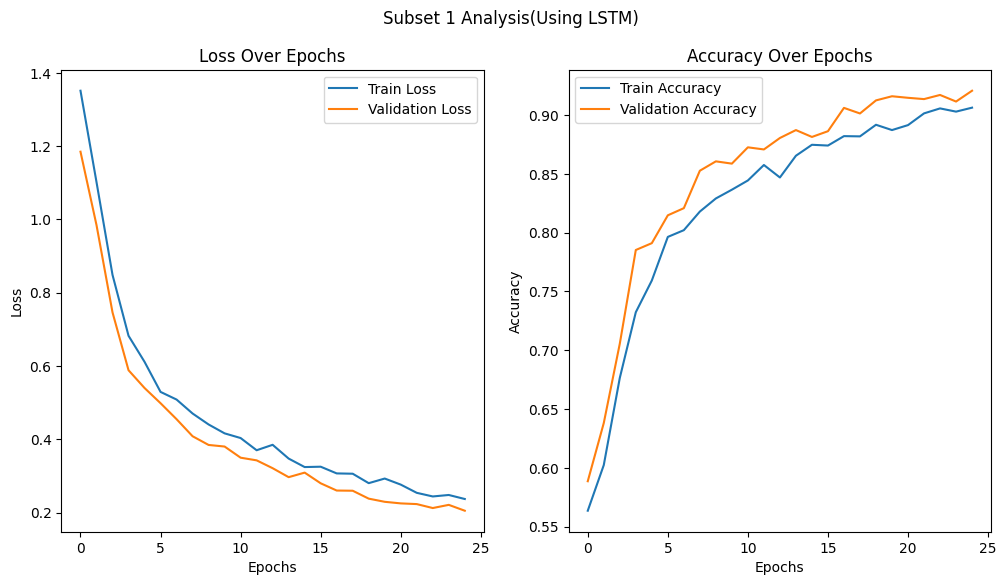

In [ ]:
# 繪製圖表方便觀察
plt.figure(figsize=(12, 6))
plt.suptitle('Subset 1 Analysis(Using LSTM)') # change here

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### **Subset 2**: Train (finetune) + Evaluate the Model

In [27]:
# 在訓練和評估時用來計算accuracy
def accuracy(pred, label):
    pred = torch.argmax(pred,dim=1)
    correct = (pred == label).float()
    return correct.mean().item()  # 計算平均accuracy

In [ ]:
########### change here ################
train_dl = train_loader_mid
validate_dl = validate_loader_mid
###########################################


train_losses = []
val_losses = []
train_accs = []
val_accs = []

model.flatten_parameters()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    tqdm_train_dl = tqdm(train_dl, desc=f'Train: epoch {epoch}')
    for inputs, labels in tqdm_train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        #print("Input shape:", inputs.shape)
        #print("Labels shape:", labels.shape)

        target_lengths = [labels.size(1) for _ in range(labels.size(0))]

        optimizer.zero_grad()

        # 預測
        output = model(inputs, target_lengths)   # 傳遞目標長度到模型
        output = output.view(-1, output.size(-1))  # 調整維度以適應CrossEntropyLoss
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(output, labels)

    # 記錄平均training loss和accuracy
    avg_train_loss = train_loss / len(train_dl)
    avg_train_acc = train_accuracy / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    tqdm_validate_dl = tqdm(validate_dl, desc=f'Validation: epoch {epoch}')
    with torch.no_grad():
        for inputs, labels in tqdm_validate_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            target_lengths = [labels.size(1) for _ in range(labels.size(0))]
            output = model(inputs, target_lengths)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(output, labels)

    # 記錄平均validation loss和accuracy
    avg_val_loss = val_loss / len(validate_dl)
    avg_val_acc = val_accuracy / len(validate_dl)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f'Epoch {epoch + 1}/{epochs}: Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Val loss: {avg_val_loss:.4f}, Val accuracy: {avg_val_acc:.4f}')
    print(100 * '-')


In [ ]:

# 繪製圖表方便觀察
plt.figure(figsize=(12, 6))
plt.suptitle('Subset 2 Analysis(Using LSTM)') # change here

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### **Subset 3**: Train (finetune) + Evaluate the Model

In [21]:
# 在訓練和評估時用來計算accuracy
def accuracy(pred, label):
    pred = torch.argmax(pred,dim=1)
    correct = (pred == label).float()
    return correct.mean().item()  # 計算平均accuracy

In [22]:
########### change here ################
train_dl = train_loader_excluded
validate_dl = validate_loader_excluded
###########################################


train_losses = []
val_losses = []
train_accs = []
val_accs = []

model.flatten_parameters()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    tqdm_train_dl = tqdm(train_dl, desc=f'Train: epoch {epoch}')
    for inputs, labels in tqdm_train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        #print("Input shape:", inputs.shape)
        #print("Labels shape:", labels.shape)

        target_lengths = [labels.size(1) for _ in range(labels.size(0))]

        optimizer.zero_grad()

        # 預測
        output = model(inputs, target_lengths)   # 傳遞目標長度到模型
        output = output.view(-1, output.size(-1))  # 調整維度以適應CrossEntropyLoss
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(output, labels)

    # 記錄平均training loss和accuracy
    avg_train_loss = train_loss / len(train_dl)
    avg_train_acc = train_accuracy / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    tqdm_validate_dl = tqdm(validate_dl, desc=f'Validation: epoch {epoch}')
    with torch.no_grad():
        for inputs, labels in tqdm_validate_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            target_lengths = [labels.size(1) for _ in range(labels.size(0))]
            output = model(inputs, target_lengths)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(output, labels)

    # 記錄平均validation loss和accuracy
    avg_val_loss = val_loss / len(validate_dl)
    avg_val_acc = val_accuracy / len(validate_dl)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f'Epoch {epoch + 1}/{epochs}: Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Val loss: {avg_val_loss:.4f}, Val accuracy: {avg_val_acc:.4f}')
    print(100 * '-')


Validation: epoch 0: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch 1/25: Train loss: 1.8461, Train accuracy: 0.4365, Val loss: 1.5634, Val accuracy: 0.4633
----------------------------------------------------------------------------------------------------


Validation: epoch 1: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 2/25: Train loss: 1.4809, Train accuracy: 0.4832, Val loss: 1.4276, Val accuracy: 0.4883
----------------------------------------------------------------------------------------------------


Validation: epoch 2: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch 3/25: Train loss: 1.4000, Train accuracy: 0.5144, Val loss: 1.3234, Val accuracy: 0.5420
----------------------------------------------------------------------------------------------------


Validation: epoch 3: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]


Epoch 4/25: Train loss: 1.2876, Train accuracy: 0.5479, Val loss: 1.2487, Val accuracy: 0.5568
----------------------------------------------------------------------------------------------------


Validation: epoch 4: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Epoch 5/25: Train loss: 1.2322, Train accuracy: 0.5597, Val loss: 1.2087, Val accuracy: 0.5613
----------------------------------------------------------------------------------------------------


Validation: epoch 5: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 6/25: Train loss: 1.1795, Train accuracy: 0.5688, Val loss: 1.1466, Val accuracy: 0.5873
----------------------------------------------------------------------------------------------------


Validation: epoch 6: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch 7/25: Train loss: 1.1266, Train accuracy: 0.5883, Val loss: 1.0925, Val accuracy: 0.6029
----------------------------------------------------------------------------------------------------


Validation: epoch 7: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch 8/25: Train loss: 1.0615, Train accuracy: 0.6090, Val loss: 1.0138, Val accuracy: 0.6267
----------------------------------------------------------------------------------------------------


Validation: epoch 8: 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


Epoch 9/25: Train loss: 1.0093, Train accuracy: 0.6264, Val loss: 0.9826, Val accuracy: 0.6291
----------------------------------------------------------------------------------------------------


Validation: epoch 9: 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


Epoch 10/25: Train loss: 0.9811, Train accuracy: 0.6328, Val loss: 0.9791, Val accuracy: 0.6373
----------------------------------------------------------------------------------------------------


Validation: epoch 10: 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


Epoch 11/25: Train loss: 0.9513, Train accuracy: 0.6442, Val loss: 0.9224, Val accuracy: 0.6571
----------------------------------------------------------------------------------------------------


Validation: epoch 11: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch 12/25: Train loss: 0.9213, Train accuracy: 0.6529, Val loss: 0.9141, Val accuracy: 0.6573
----------------------------------------------------------------------------------------------------


Validation: epoch 12: 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch 13/25: Train loss: 0.9051, Train accuracy: 0.6571, Val loss: 0.8929, Val accuracy: 0.6632
----------------------------------------------------------------------------------------------------


Validation: epoch 13: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch 14/25: Train loss: 0.8882, Train accuracy: 0.6627, Val loss: 0.9225, Val accuracy: 0.6524
----------------------------------------------------------------------------------------------------


Validation: epoch 14: 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch 15/25: Train loss: 0.8869, Train accuracy: 0.6624, Val loss: 0.8750, Val accuracy: 0.6684
----------------------------------------------------------------------------------------------------


Validation: epoch 15: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


Epoch 16/25: Train loss: 0.8635, Train accuracy: 0.6697, Val loss: 0.8726, Val accuracy: 0.6658
----------------------------------------------------------------------------------------------------


Validation: epoch 16: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch 17/25: Train loss: 0.8435, Train accuracy: 0.6759, Val loss: 0.8462, Val accuracy: 0.6745
----------------------------------------------------------------------------------------------------


Validation: epoch 17: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


Epoch 18/25: Train loss: 0.8377, Train accuracy: 0.6790, Val loss: 0.8510, Val accuracy: 0.6728
----------------------------------------------------------------------------------------------------


Validation: epoch 18: 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


Epoch 19/25: Train loss: 0.8273, Train accuracy: 0.6823, Val loss: 0.8348, Val accuracy: 0.6767
----------------------------------------------------------------------------------------------------


Validation: epoch 19: 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch 20/25: Train loss: 0.8163, Train accuracy: 0.6861, Val loss: 0.8246, Val accuracy: 0.6827
----------------------------------------------------------------------------------------------------


Validation: epoch 20: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch 21/25: Train loss: 0.8015, Train accuracy: 0.6928, Val loss: 0.8422, Val accuracy: 0.6750
----------------------------------------------------------------------------------------------------


Validation: epoch 21: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch 22/25: Train loss: 0.7928, Train accuracy: 0.6941, Val loss: 0.8118, Val accuracy: 0.6876
----------------------------------------------------------------------------------------------------


Validation: epoch 22: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


Epoch 23/25: Train loss: 0.7876, Train accuracy: 0.6952, Val loss: 0.8021, Val accuracy: 0.6863
----------------------------------------------------------------------------------------------------


Validation: epoch 23: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch 24/25: Train loss: 0.7686, Train accuracy: 0.7016, Val loss: 0.7828, Val accuracy: 0.6969
----------------------------------------------------------------------------------------------------


Validation: epoch 24: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

Epoch 25/25: Train loss: 0.7510, Train accuracy: 0.7042, Val loss: 0.7679, Val accuracy: 0.6978
----------------------------------------------------------------------------------------------------


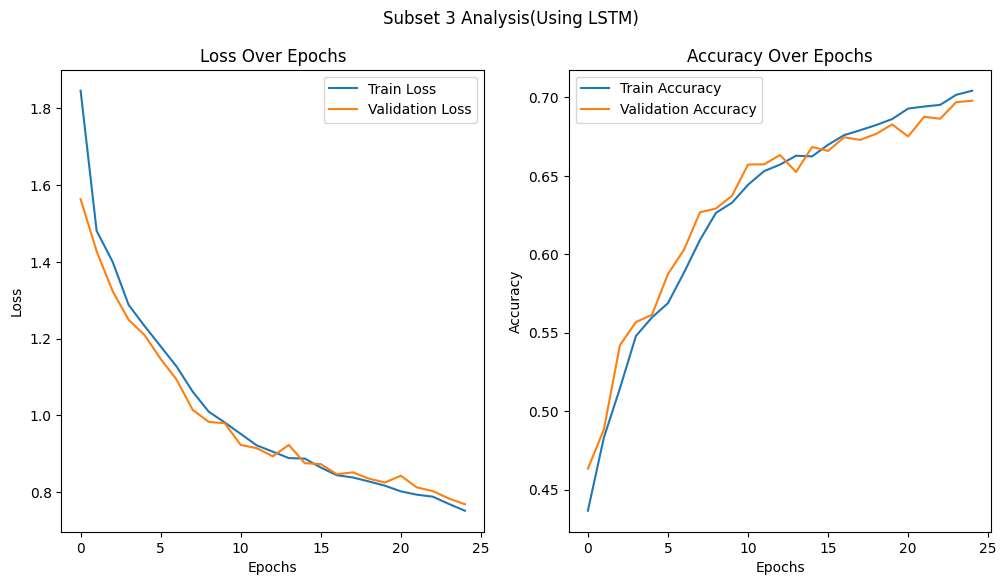

In [23]:

# 繪製圖表方便觀察
plt.figure(figsize=(12, 6))
plt.suptitle('Subset 3 Analysis(Using LSTM)') # change here

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### **Full Data**: Train (finetune) + Evaluate the Model

In [24]:
# 在訓練和評估時用來計算accuracy
def accuracy(pred, label):
    pred = torch.argmax(pred,dim=1)
    correct = (pred == label).float()
    return correct.mean().item()  # 計算平均accuracy

In [25]:
########### change here ################
train_dl = train_loader_full
validate_dl = validate_loader_full
###########################################


train_losses = []
val_losses = []
train_accs = []
val_accs = []

model.flatten_parameters()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    tqdm_train_dl = tqdm(train_dl, desc=f'Train: epoch {epoch}')
    for inputs, labels in tqdm_train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        #print("Input shape:", inputs.shape)
        #print("Labels shape:", labels.shape)

        target_lengths = [labels.size(1) for _ in range(labels.size(0))]

        optimizer.zero_grad()

        # 預測
        output = model(inputs, target_lengths)   # 傳遞目標長度到模型
        output = output.view(-1, output.size(-1))  # 調整維度以適應CrossEntropyLoss
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(output, labels)

    # 記錄平均training loss和accuracy
    avg_train_loss = train_loss / len(train_dl)
    avg_train_acc = train_accuracy / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    tqdm_validate_dl = tqdm(validate_dl, desc=f'Validation: epoch {epoch}')
    with torch.no_grad():
        for inputs, labels in tqdm_validate_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            target_lengths = [labels.size(1) for _ in range(labels.size(0))]
            output = model(inputs, target_lengths)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(output, labels)

    # 記錄平均validation loss和accuracy
    avg_val_loss = val_loss / len(validate_dl)
    avg_val_acc = val_accuracy / len(validate_dl)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f'Epoch {epoch + 1}/{epochs}: Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Val loss: {avg_val_loss:.4f}, Val accuracy: {avg_val_acc:.4f}')
    print(100 * '-')


Validation: epoch 0: 100%|██████████| 11/11 [00:02<00:00,  5.46it/s]


Epoch 1/25: Train loss: 0.9850, Train accuracy: 0.6418, Val loss: 0.8426, Val accuracy: 0.6747
----------------------------------------------------------------------------------------------------


Validation: epoch 1: 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]


Epoch 2/25: Train loss: 0.8274, Train accuracy: 0.6769, Val loss: 0.8069, Val accuracy: 0.6804
----------------------------------------------------------------------------------------------------


Validation: epoch 2: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]


Epoch 3/25: Train loss: 0.7952, Train accuracy: 0.6868, Val loss: 0.7913, Val accuracy: 0.6880
----------------------------------------------------------------------------------------------------


Validation: epoch 3: 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


Epoch 4/25: Train loss: 0.7756, Train accuracy: 0.6939, Val loss: 0.7708, Val accuracy: 0.6941
----------------------------------------------------------------------------------------------------


Validation: epoch 4: 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]


Epoch 5/25: Train loss: 0.7635, Train accuracy: 0.6983, Val loss: 0.7784, Val accuracy: 0.6907
----------------------------------------------------------------------------------------------------


Validation: epoch 5: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 6/25: Train loss: 0.7587, Train accuracy: 0.6994, Val loss: 0.7619, Val accuracy: 0.6947
----------------------------------------------------------------------------------------------------


Validation: epoch 6: 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]


Epoch 7/25: Train loss: 0.7411, Train accuracy: 0.7057, Val loss: 0.7616, Val accuracy: 0.6952
----------------------------------------------------------------------------------------------------


Validation: epoch 7: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch 8/25: Train loss: 0.7296, Train accuracy: 0.7107, Val loss: 0.7619, Val accuracy: 0.6954
----------------------------------------------------------------------------------------------------


Validation: epoch 8: 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]


Epoch 9/25: Train loss: 0.7209, Train accuracy: 0.7106, Val loss: 0.7208, Val accuracy: 0.7039
----------------------------------------------------------------------------------------------------


Validation: epoch 9: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]


Epoch 10/25: Train loss: 0.6868, Train accuracy: 0.7183, Val loss: 0.7092, Val accuracy: 0.7073
----------------------------------------------------------------------------------------------------


Validation: epoch 10: 100%|██████████| 11/11 [00:01<00:00,  5.57it/s]


Epoch 11/25: Train loss: 0.6726, Train accuracy: 0.7205, Val loss: 0.7002, Val accuracy: 0.7065
----------------------------------------------------------------------------------------------------


Validation: epoch 11: 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 12/25: Train loss: 0.6560, Train accuracy: 0.7244, Val loss: 0.6761, Val accuracy: 0.7113
----------------------------------------------------------------------------------------------------


Validation: epoch 12: 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]


Epoch 13/25: Train loss: 0.6441, Train accuracy: 0.7281, Val loss: 0.6793, Val accuracy: 0.7106
----------------------------------------------------------------------------------------------------


Validation: epoch 13: 100%|██████████| 11/11 [00:02<00:00,  5.50it/s]


Epoch 14/25: Train loss: 0.6309, Train accuracy: 0.7327, Val loss: 0.6640, Val accuracy: 0.7142
----------------------------------------------------------------------------------------------------


Validation: epoch 14: 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


Epoch 15/25: Train loss: 0.6239, Train accuracy: 0.7346, Val loss: 0.6598, Val accuracy: 0.7144
----------------------------------------------------------------------------------------------------


Validation: epoch 15: 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]


Epoch 16/25: Train loss: 0.6200, Train accuracy: 0.7378, Val loss: 0.6622, Val accuracy: 0.7133
----------------------------------------------------------------------------------------------------


Validation: epoch 16: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]


Epoch 17/25: Train loss: 0.6150, Train accuracy: 0.7386, Val loss: 0.6724, Val accuracy: 0.7096
----------------------------------------------------------------------------------------------------


Validation: epoch 17: 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]


Epoch 18/25: Train loss: 0.6104, Train accuracy: 0.7413, Val loss: 0.6654, Val accuracy: 0.7159
----------------------------------------------------------------------------------------------------


Validation: epoch 18: 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 19/25: Train loss: 0.6013, Train accuracy: 0.7447, Val loss: 0.6558, Val accuracy: 0.7193
----------------------------------------------------------------------------------------------------


Validation: epoch 19: 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]


Epoch 20/25: Train loss: 0.5985, Train accuracy: 0.7468, Val loss: 0.6566, Val accuracy: 0.7170
----------------------------------------------------------------------------------------------------


Validation: epoch 20: 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]


Epoch 21/25: Train loss: 0.5955, Train accuracy: 0.7465, Val loss: 0.6545, Val accuracy: 0.7216
----------------------------------------------------------------------------------------------------


Validation: epoch 21: 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


Epoch 22/25: Train loss: 0.5934, Train accuracy: 0.7482, Val loss: 0.6400, Val accuracy: 0.7260
----------------------------------------------------------------------------------------------------


Validation: epoch 22: 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 23/25: Train loss: 0.5855, Train accuracy: 0.7517, Val loss: 0.6589, Val accuracy: 0.7200
----------------------------------------------------------------------------------------------------


Validation: epoch 23: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]


Epoch 24/25: Train loss: 0.5819, Train accuracy: 0.7551, Val loss: 0.6405, Val accuracy: 0.7250
----------------------------------------------------------------------------------------------------


Validation: epoch 24: 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

Epoch 25/25: Train loss: 0.5832, Train accuracy: 0.7557, Val loss: 0.6509, Val accuracy: 0.7251
----------------------------------------------------------------------------------------------------


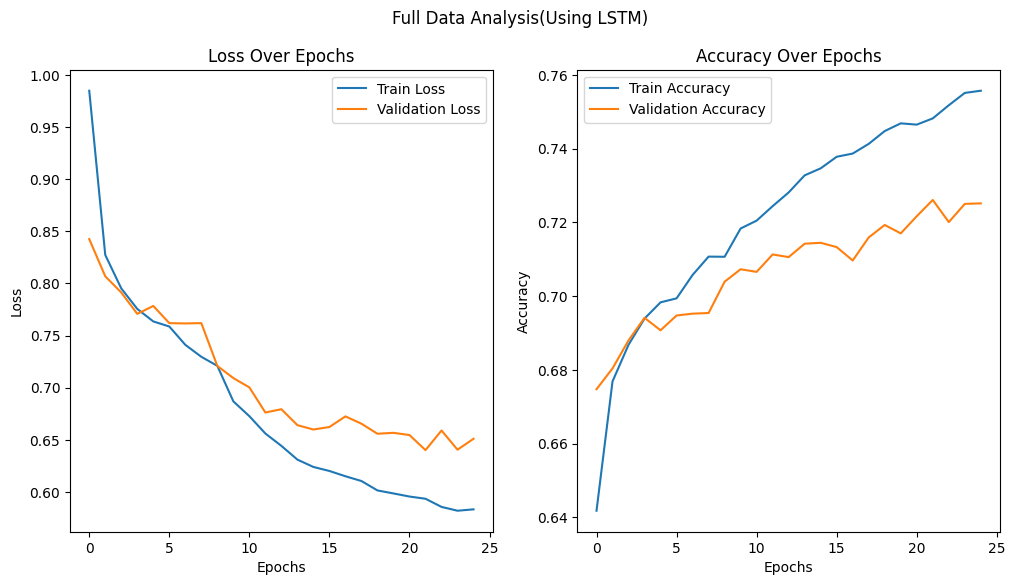

In [26]:

# 繪製圖表方便觀察
plt.figure(figsize=(12, 6))
plt.suptitle('Full Data Analysis(Using LSTM)') # change here

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Part 2: Bonus --- 不同model比較 (以subset 1為例)


In [ ]:

vocab_size = len(train_ds_full.char_to_id)
batch_size = 256
epochs = 25
embed_dim = 256
hidden_dim = 256
encode_n_layers = 2
decode_n_layers = 2
lr = 0.001
rnn_type = "GRU"
grad_clip = 2     # 用於防止梯度爆炸


In [ ]:
model = ArithmeticModel(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim,
             encode_n_layers=encode_n_layers, decode_n_layers=decode_n_layers, rnn_type=rnn_type)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()   # 因為是分類問題
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


In [ ]:
# 在訓練和評估時用來計算accuracy
def accuracy(pred, label):
    pred = torch.argmax(pred,dim=1)
    correct = (pred == label).float()
    return correct.mean().item()  # 計算平均accuracy

In [ ]:
########### change here ################
train_dl = train_loader_small
validate_dl = validate_loader_small
###########################################


train_losses = []
val_losses = []
train_accs = []
val_accs = []

model.flatten_parameters()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    tqdm_train_dl = tqdm(train_dl, desc=f'Train: epoch {epoch}')
    for inputs, labels in tqdm_train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        #print("Input shape:", inputs.shape)
        #print("Labels shape:", labels.shape)

        target_lengths = [labels.size(1) for _ in range(labels.size(0))]

        optimizer.zero_grad()

        # 預測
        output = model(inputs, target_lengths)    # 傳遞目標長度到模型
        output = output.view(-1, output.size(-1))  # 調整維度以適應CrossEntropyLoss
        labels = labels.view(-1)

        loss = criterion(output, labels)
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(output, labels)

    # 記錄平均training loss和accuracy
    avg_train_loss = train_loss / len(train_dl)
    avg_train_acc = train_accuracy / len(train_dl)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    tqdm_validate_dl = tqdm(validate_dl, desc=f'Validation: epoch {epoch}')
    with torch.no_grad():
        for inputs, labels in tqdm_validate_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            target_lengths = [labels.size(1) for _ in range(labels.size(0))]
            output = model(inputs, target_lengths)
            output = output.view(-1, output.size(-1))
            labels = labels.view(-1)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(output, labels)

    # 記錄平均validation loss和accuracy
    avg_val_loss = val_loss / len(validate_dl)
    avg_val_acc = val_accuracy / len(validate_dl)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f'Epoch {epoch + 1}/{epochs}: Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Val loss: {avg_val_loss:.4f}, Val accuracy: {avg_val_acc:.4f}')
    print(100 * '-')


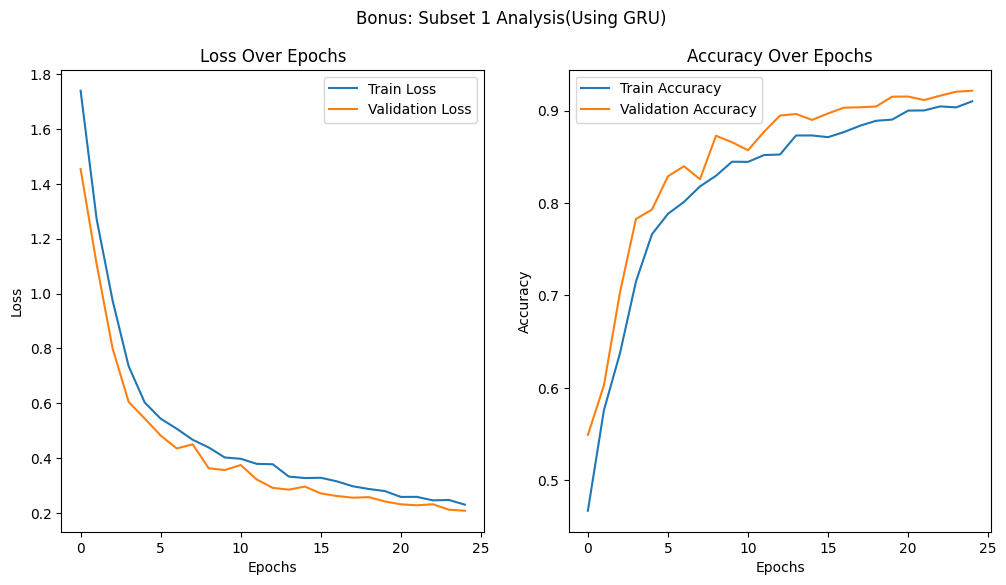

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Bonus: Subset 1 Analysis(Using GRU)') # change here

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()